<a href="https://www.kaggle.com/yousseftaoudi/football-match-prediction-eda?scriptVersionId=89986842" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

df = pd.read_csv("../input/football-match-probability-prediction/train.csv")
for i in df.columns:
    print(i)
    


id
target
home_team_name
away_team_name
match_date
league_name
league_id
is_cup
home_team_coach_id
away_team_coach_id
home_team_history_match_date_1
home_team_history_match_date_2
home_team_history_match_date_3
home_team_history_match_date_4
home_team_history_match_date_5
home_team_history_match_date_6
home_team_history_match_date_7
home_team_history_match_date_8
home_team_history_match_date_9
home_team_history_match_date_10
home_team_history_is_play_home_1
home_team_history_is_play_home_2
home_team_history_is_play_home_3
home_team_history_is_play_home_4
home_team_history_is_play_home_5
home_team_history_is_play_home_6
home_team_history_is_play_home_7
home_team_history_is_play_home_8
home_team_history_is_play_home_9
home_team_history_is_play_home_10
home_team_history_is_cup_1
home_team_history_is_cup_2
home_team_history_is_cup_3
home_team_history_is_cup_4
home_team_history_is_cup_5
home_team_history_is_cup_6
home_team_history_is_cup_7
home_team_history_is_cup_8
home_team_history_is_cup

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


I would also suggest taking a look at this EDA by a different kaggle user: https://www.kaggle.com/aliphya/football-match-probability-prediction-eda

## Exploring Team Performances (Home & Away games + cup games)

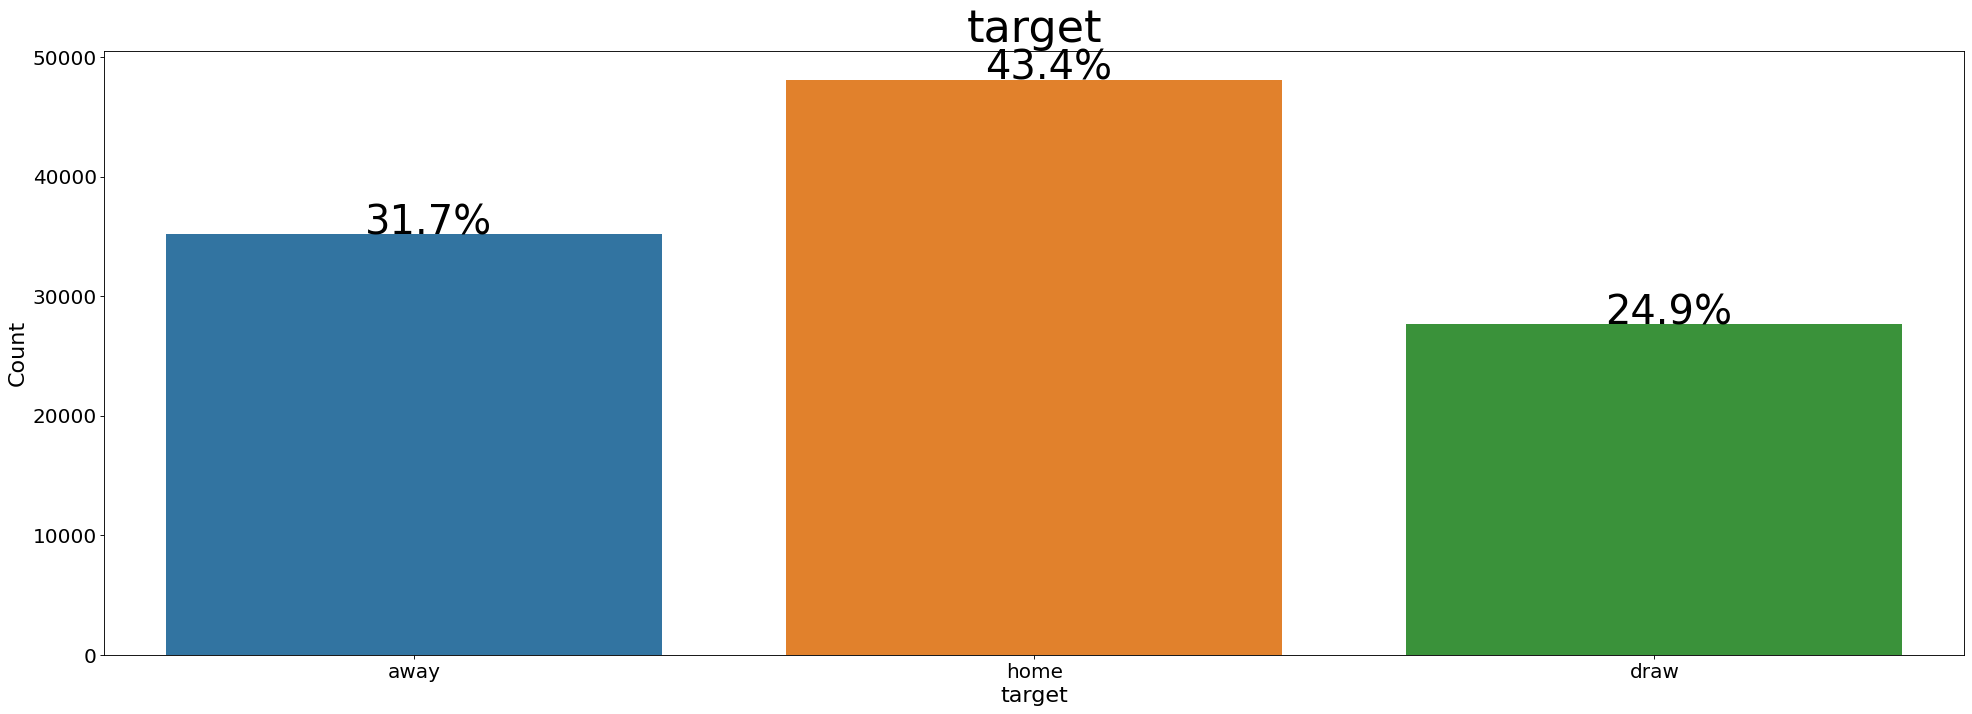

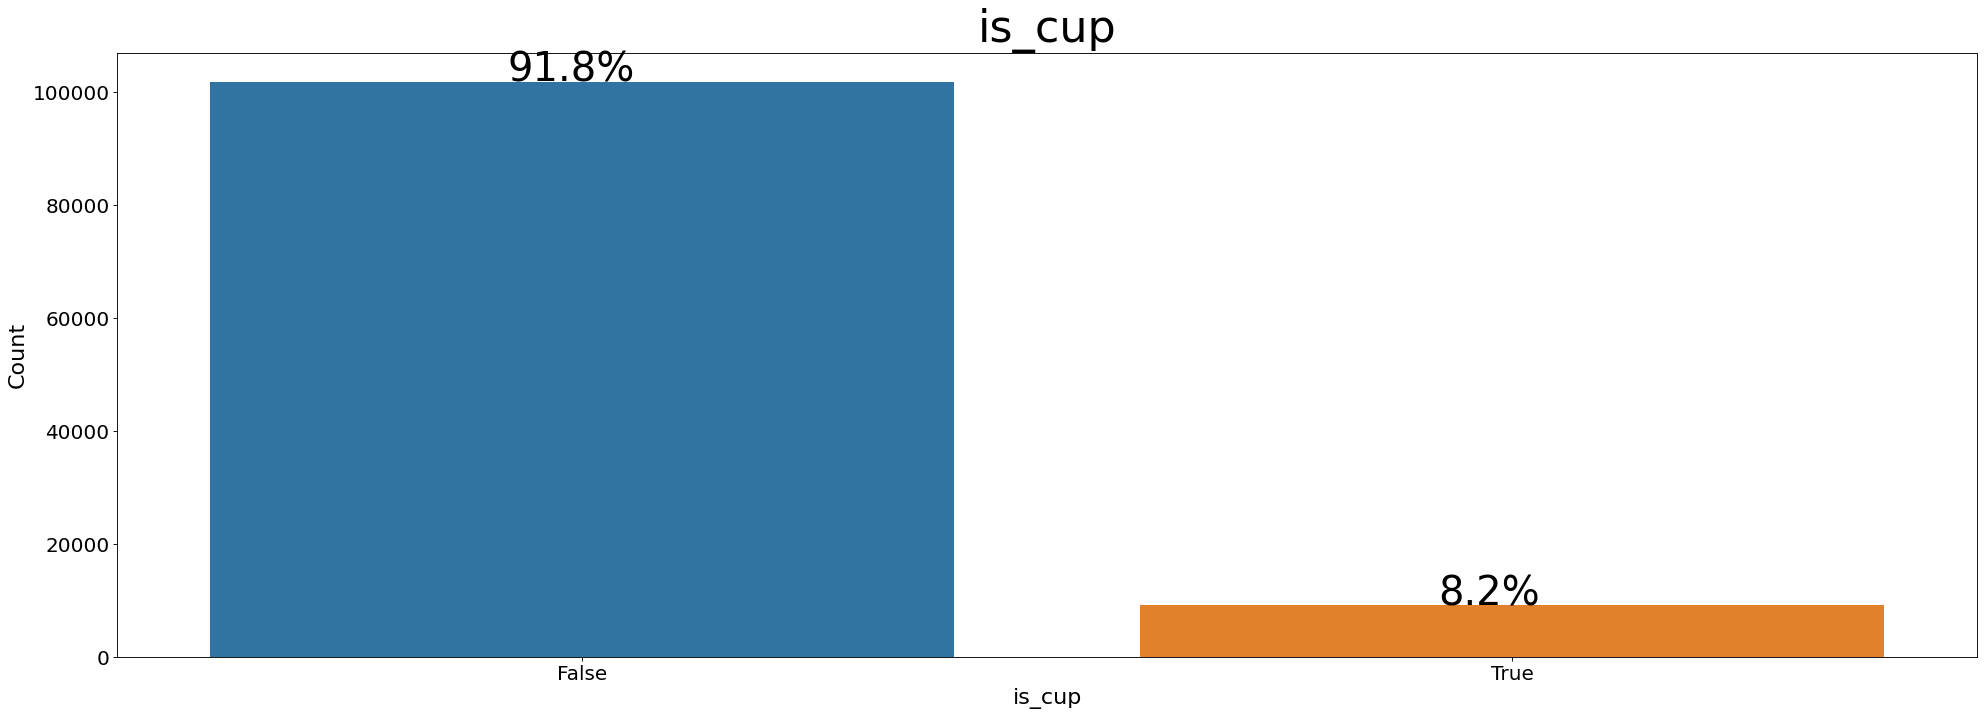

In [2]:
import seaborn as sns
from matplotlib.pyplot import figure


def without_hue(ax, feature,shift=0.08):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - shift
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 36)


features = ['target','is_cup']
sns.color_palette("crest", as_cmap=True)

for col in features:
    figure(figsize=(30, 10), dpi=80)
    ax = sns.countplot(x = df[col])
    plt.title(col, fontsize=40)
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel('Count',fontsize=20)
    without_hue(ax,df[col])
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

    


target - The target is characterized as the outcome of a match. 'Home' means that the home team won, 'Away' means that the away team won and 'Draw' means that the game resulted in a draw. The data is fairly balanced with 'Home' making up 41% of the targets. This does make sense as the home team is generally seen as having an advantage due to familiarity with the pitch and support from fans during the game.

is_cup - The vast majority of games are not cup games. One idea could be to create a seperate model for cup games as the patterns between cup and league game may differ, especially for cup games that play with the home advantage rules.

The win/draw/loss rates don't change very much across league, cup and frienly matches. The only noticable difference is that cup games have a bit more away wins, friendly games have more home wins and league games have more draws.

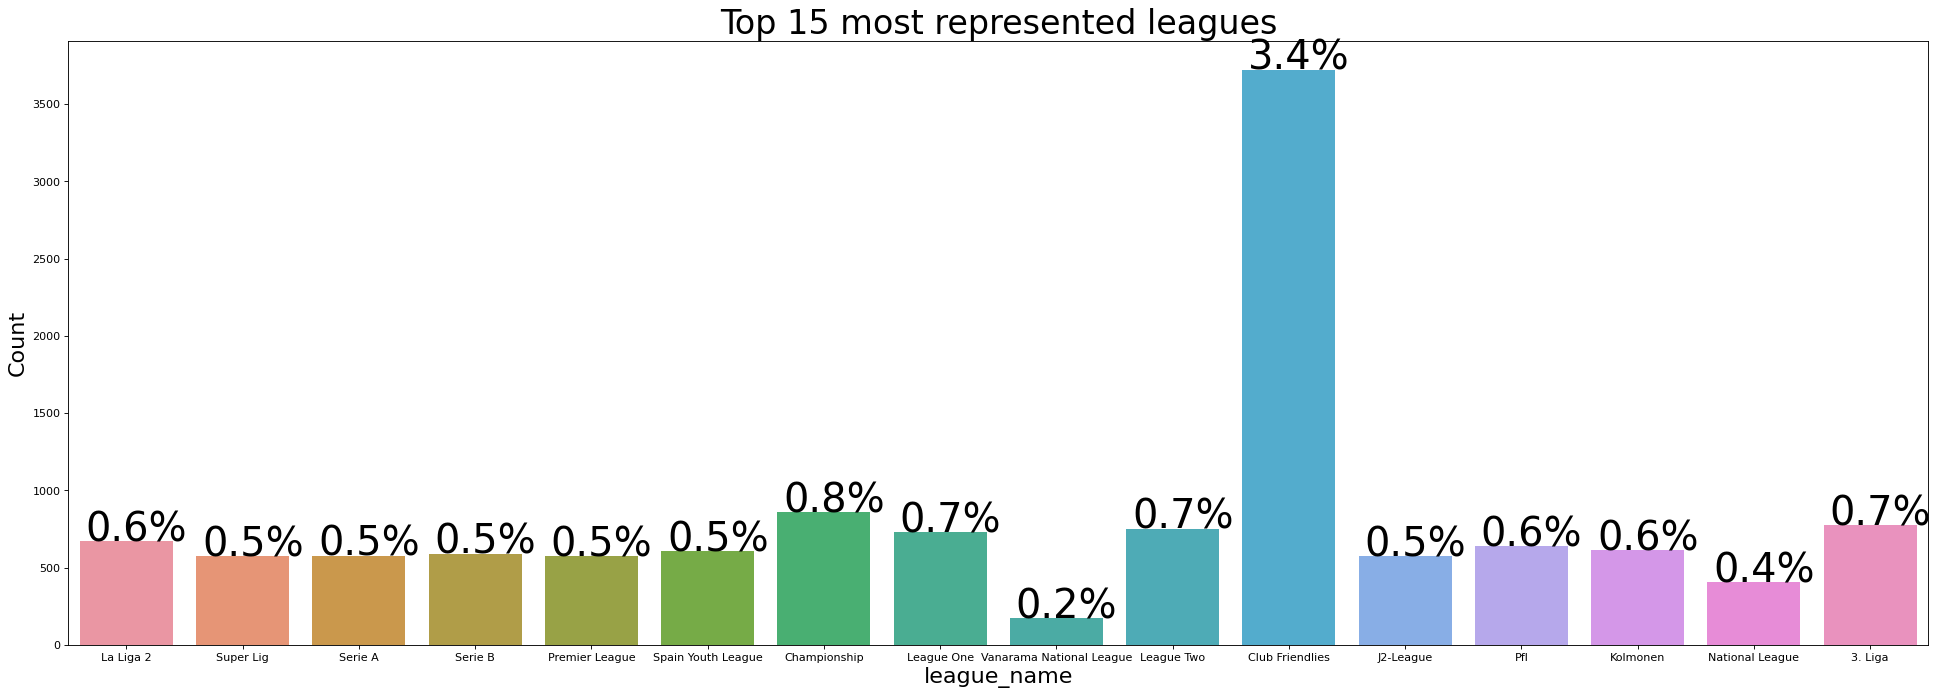

In [3]:
figure(figsize=(30, 10), dpi=80)
n = 15
sns.color_palette("crest", as_cmap=True)

col = 'league_name'
leagues = df['league_id'].value_counts()[:n].index.tolist()
ax = sns.countplot(x = df[df['league_id'].isin(leagues)][col])
plt.title("Top 15 most represented leagues",fontsize=30)
ax.set_xlabel(col, fontsize=20)
ax.set_ylabel('Count',fontsize=20)
without_hue(ax,df['league_id'],shift=0.35)

plt.show()

The distribution of leagues is fairly even with the small exception of "Club Friendlies". One idea could be to filter out all club friendlies or add them as a seperate feature similar to is_cup since many teams don't field strong XIs for such games. Note that the plot only displays the top 15 represented leagues which only make up a small part of the data.

<Figure size 2400x800 with 0 Axes>

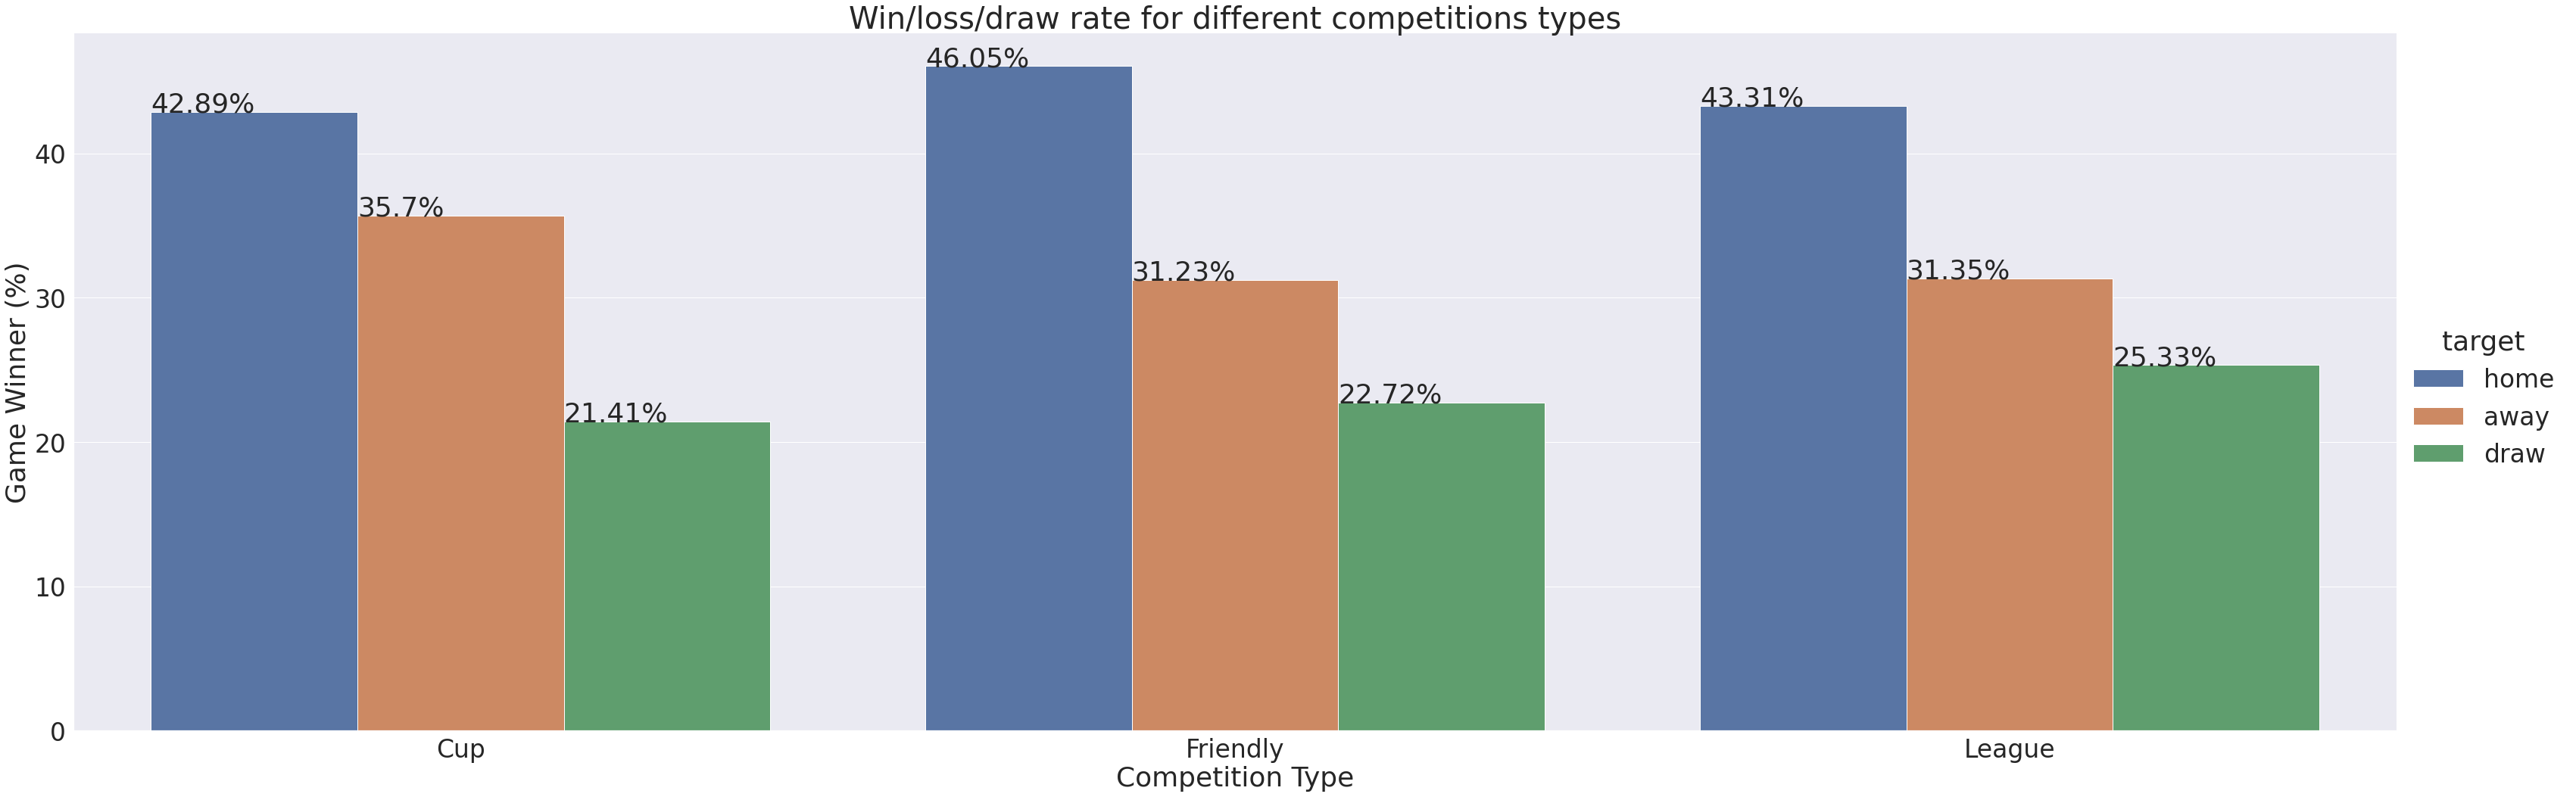

In [4]:
import seaborn as sns
from matplotlib.pyplot import figure


    

df2 = df.copy(deep=True)
df2.loc[df2['is_cup'] == False,'game_type'] = 'League'
df2.loc[df2['is_cup'] == True,'game_type'] = 'Cup'
df2.loc[df2['league_name'] == 'Club Friendlies','game_type'] = 'Friendly'

df1 = df2.groupby('game_type')['target'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

features = ['target','game_type']
sns.color_palette("crest", as_cmap=True)
figure(figsize=(30, 10), dpi=80)
sns.set(font_scale=3)  # crazy big

g = sns.catplot(x="game_type",y='percent',hue='target',kind='bar',data=df1,height=15,aspect=3)
plt.title("Win/loss/draw rate for different competitions types", fontsize=40)
g.set_axis_labels("Competition Type","Game Winner (%)")
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.show()




/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<Figure size 2160x720 with 0 Axes>

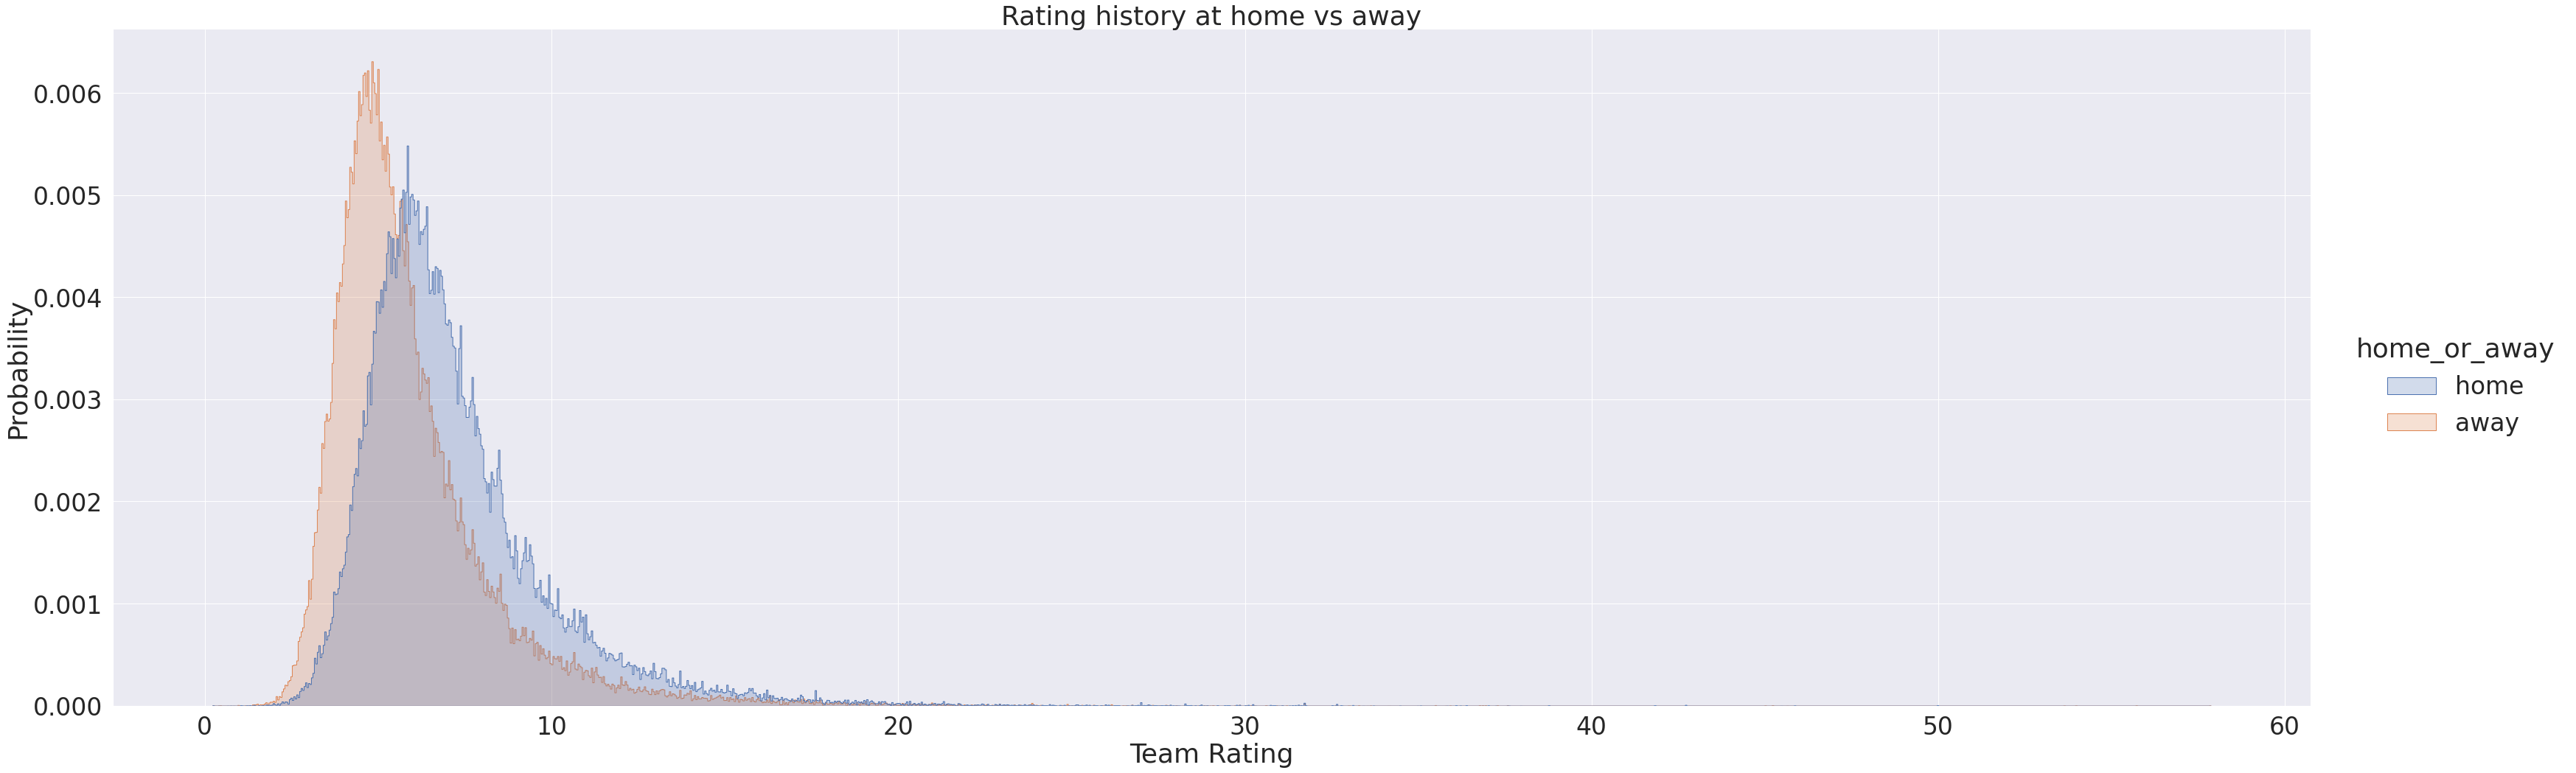

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


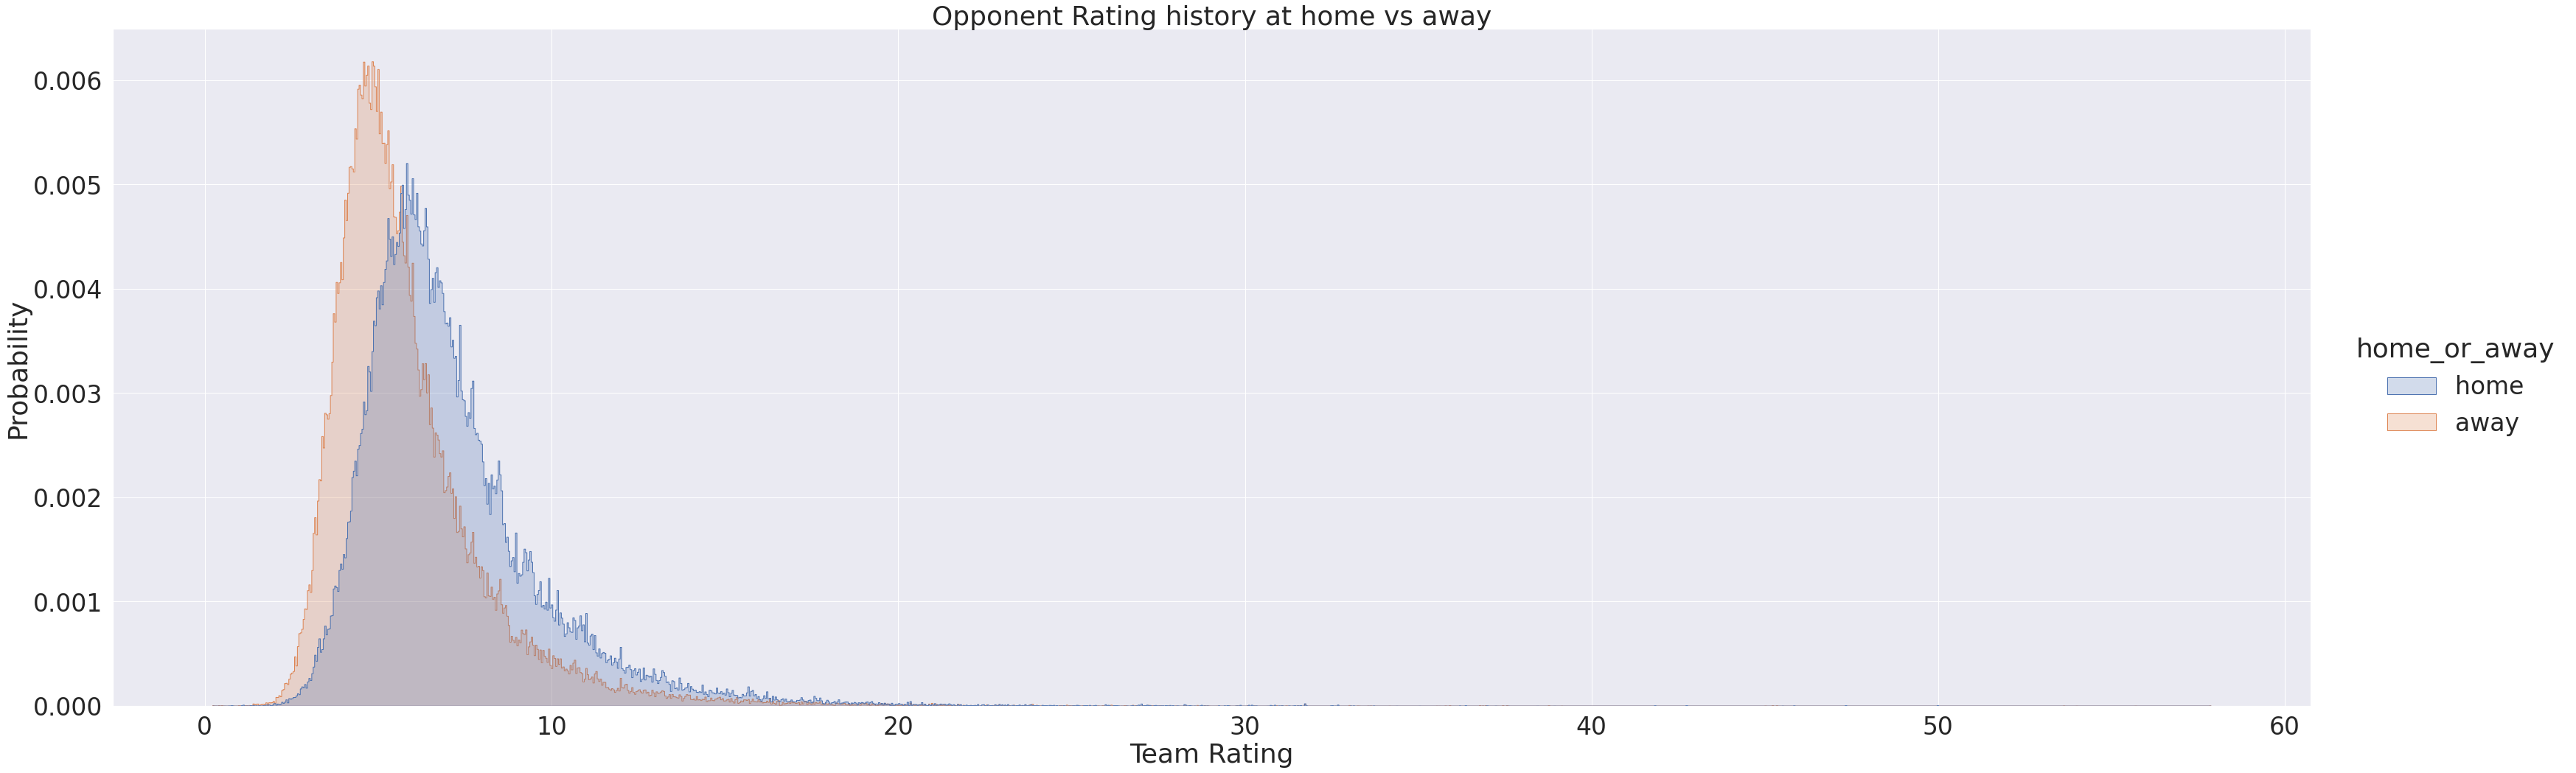

In [5]:
s = 'away_team_history_rating_'
s2 = 'home_team_history_rating_'
s3 = 'away_team_history_opponent_rating_'
s4 = 'home_team_history_opponent_rating_'
s_id = 'away_team_history_league_id'
s_id = 'home_team_history_league_id'

p = "away_team_history_is_play_home_"
p2 = "home_team_history_is_play_home_"
p3 = "away_team_opponent_history_is_play_home_"
p4 = "home_team_opponent_history_is_play_home_"

column_names = ["date"]
new_df = pd.DataFrame(columns = column_names)

history_df = df.loc[:, df.columns.str.contains(p)|df.columns.str.contains(p2)\
                    |df.columns.str.contains(s)|df.columns.str.contains(s2)|df.columns.str.contains(s3)|df.columns.str.contains(s4)|(df.columns == 'id')|(df.columns=='match_date')]
history_df = pd.wide_to_long(history_df, stubnames=[s,s2,s3,s4,p,p2,p3,p4], i="id",j='i')


style.use(style='seaborn')
plt.figure(figsize=(30,10))


history_df.loc[history_df[p2]==0.0,p4] = 'home'
history_df.loc[history_df[p2]==1.0,p4] = 'away'
history_df.loc[history_df[p]==0.0,p3] = 'home'
history_df.loc[history_df[p]==1.0,p3] = 'away'


history_df.loc[history_df[p2]==0.0,p2] = 'away'
history_df.loc[history_df[p2]==1.0,p2] = 'home'
history_df.loc[history_df[p]==0.0,p] = 'away'
history_df.loc[history_df[p]==1.0,p] = 'home'

order = ['home','away']

sns.set(font_scale=3)  # crazy big

res = pd.DataFrame(columns=['ratings','home_or_away'])
ps = [p,p2]
for i, v in enumerate([s,s2]):
    temp = history_df[[v,ps[i]]]
    temp.rename(columns={v: 'ratings', ps[i]: 'home_or_away'}, inplace=True)
    res = pd.concat([res,temp], axis=0)
res.reset_index(inplace=True)
ax = sns.displot(res,x='ratings',fill=True,element="step",kde=False,rug=False,hue='home_or_away',height=15,aspect=3,hue_order=order,stat="probability")
ax.set_axis_labels("Team Rating","Probability")
plt.title("Rating history at home vs away")
plt.show()


res = pd.DataFrame(columns=['ratings','home_or_away'])
ps = [p3,p4]
for i, v in enumerate([s3,s4]):
    temp = history_df[[v,ps[i]]]
    temp.rename(columns={v: 'ratings', ps[i]: 'home_or_away'}, inplace=True)
    res = pd.concat([res,temp], axis=0)
res.reset_index(inplace=True)
ax = sns.displot(res,x='ratings',fill=True,element="step",kde=False,rug=False,hue='home_or_away',height=15,aspect=3,hue_order=order,stat="probability")
ax.set_axis_labels("Team Rating","Probability")
plt.title("Opponent Rating history at home vs away")
plt.show()

By stacking and visualizing the history ratings over home and away games, we can clearly see that match ratings are generally higher when playing at home.

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<Figure size 2160x720 with 0 Axes>

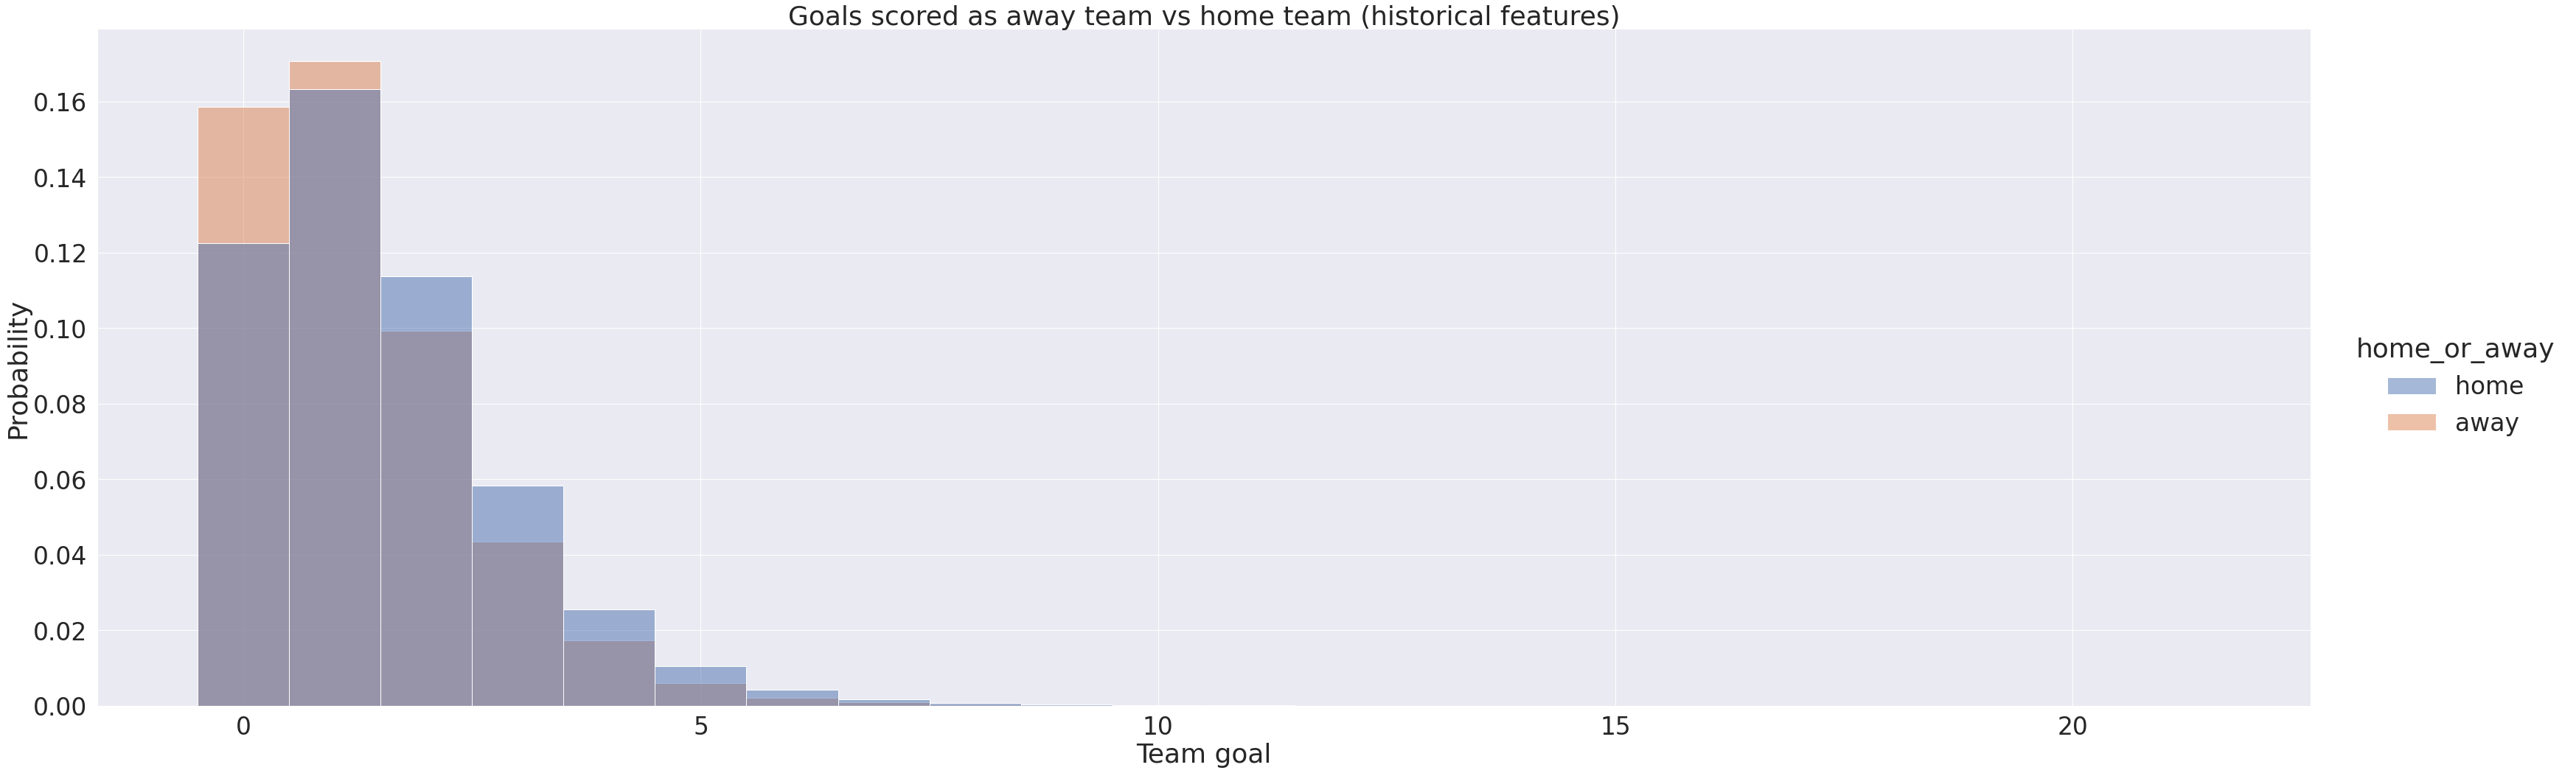

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


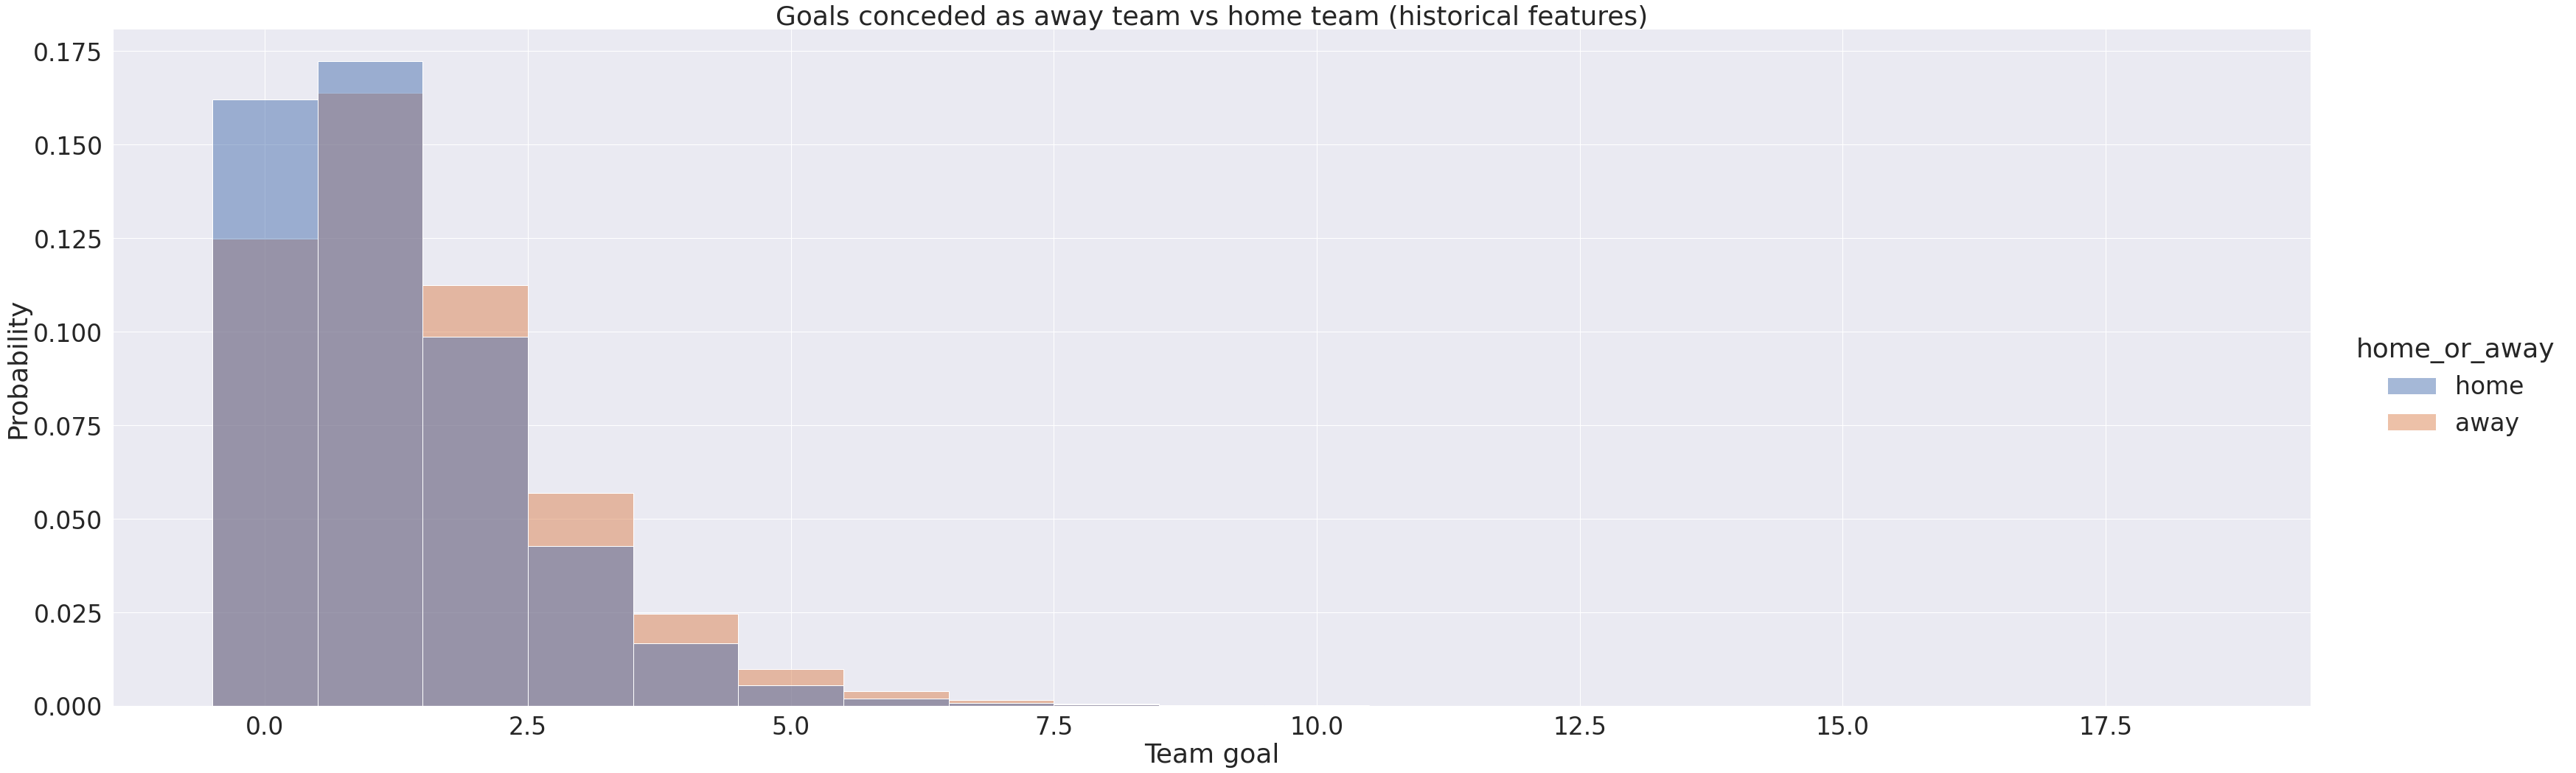

In [6]:
s2 = 'away_team_history_goal_'
s = 'home_team_history_goal_'
s4 = 'away_team_history_opponent_goal_'
s3 = 'home_team_history_opponent_goal_'
s_id = 'away_team_history_league_id'
s_id = 'home_team_history_league_id'

p2 = "away_team_history_is_play_home_"
p = "home_team_history_is_play_home_"
p4 = "away_team_opponent_history_is_play_home_"
p3 = "home_team_opponent_history_is_play_home_"

column_names = ["date"]
order = ['home','away']

new_df = pd.DataFrame(columns = column_names)

history_df = df.loc[:, df.columns.str.contains(p)|df.columns.str.contains(p2)\
                    |df.columns.str.contains(s)|df.columns.str.contains(s2)|df.columns.str.contains(s3)|df.columns.str.contains(s4)|(df.columns == 'id')|(df.columns=='match_date')]
history_df = pd.wide_to_long(history_df, stubnames=[s,s2,s3,s4,p,p2,p3,p4], i="id",j='i')


style.use(style='seaborn')
plt.figure(figsize=(30,10))


history_df.loc[history_df[p2]==1.0,p4] = 'home'
history_df.loc[history_df[p2]==0.0,p4] = 'away'
history_df.loc[history_df[p]==1.0,p3] = 'home'
history_df.loc[history_df[p]==0.0,p3] = 'away'


history_df.loc[history_df[p2]==1.0,p2] = 'home'
history_df.loc[history_df[p2]==0.0,p2] = 'away'
history_df.loc[history_df[p]==1.0,p] = 'home'
history_df.loc[history_df[p]==0.0,p] = 'away'

order = ['home','away']

sns.set(font_scale=3)  # crazy big

res = pd.DataFrame(columns=['goals','home_or_away'])
ps = [p,p2]
for i, v in enumerate([s,s2]):
    temp = history_df[[v,ps[i]]]
    temp.rename(columns={v: 'goals', ps[i]: 'home_or_away'}, inplace=True)
    res = pd.concat([res,temp])
res.reset_index(inplace=True)

ax = sns.displot(x='goals',hue='home_or_away',element='bars',data=res,height=15,aspect=3,discrete=True,hue_order=order,stat="probability")
ax.set_axis_labels("Team goal","Probability")
plt.title("Goals scored as away team vs home team (historical features)")
plt.show()


res = pd.DataFrame(columns=['goals','home_or_away'])
ps = [p3,p4]
for i, v in enumerate([s3,s4]):
    temp = history_df[[v,ps[i]]]
    temp.rename(columns={v: 'goals', ps[i]: 'home_or_away'}, inplace=True)
    res = pd.concat([res,temp])
res.reset_index(inplace=True)

ax = sns.displot(x='goals',hue='home_or_away',element='bars',data=res,height=15,aspect=3,discrete=True,hue_order=order,stat="probability")
ax.set_axis_labels("Team goal","Probability")
plt.title("Goals conceded as away team vs home team (historical features)")
plt.show()

By adding up all counts of  goals scored/conceded aggregated by away/home sides, we can visualize how the distribution of goal scoring changes depending on whether or not a team is playing at home or away. One can see from the histograms that the home-team generally has a slight advantage as they more frequently score 2 or more goals. The away team also more frequently concede 2 or more goals.

The two plots are mirrors of each other since the goals score by the away team in the top plot is the same as goals conceded by the home team in the second plot.

## Match dates, match date history and seasonality

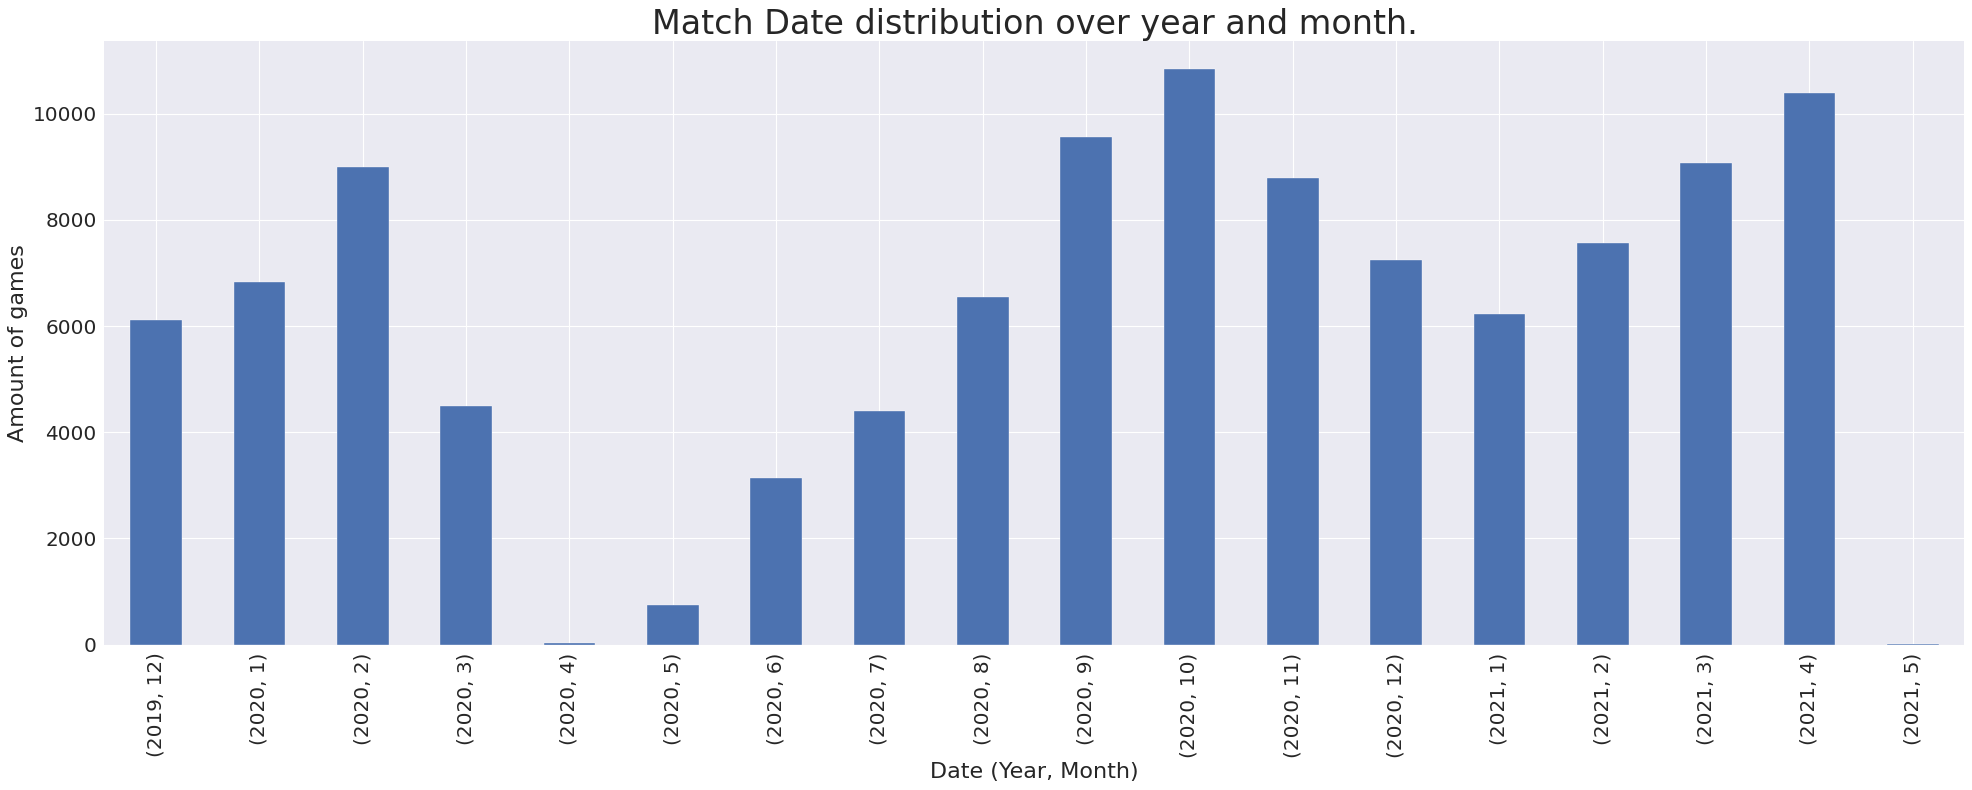

In [7]:

df['date'] = pd.to_datetime(df['match_date'], errors='coerce')

figure(figsize=(30, 10), dpi=80)
style.use(style='seaborn')
ax = df.groupby([df["date"].dt.year, df["date"].dt.month])['date'].count().plot(kind="bar", x='Match Date', y='Count')
ax.set_title("Match Date distribution over year and month.",fontsize=30)
ax.set_xlabel("Date (Year, Month)",fontsize=20)
ax.set_ylabel("Amount of games",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)


All games were played during the 2019/20 and 2020/21 seasons. This might cause an issue since many games might have been played without fans due to COVID19, which football fans know is a big disadvantage for the home teams. The advantage of having lots of data for only recent seasons is that the football that was played during this time should be fairly similar to the football that is played today in terms of tactics and playstyles.

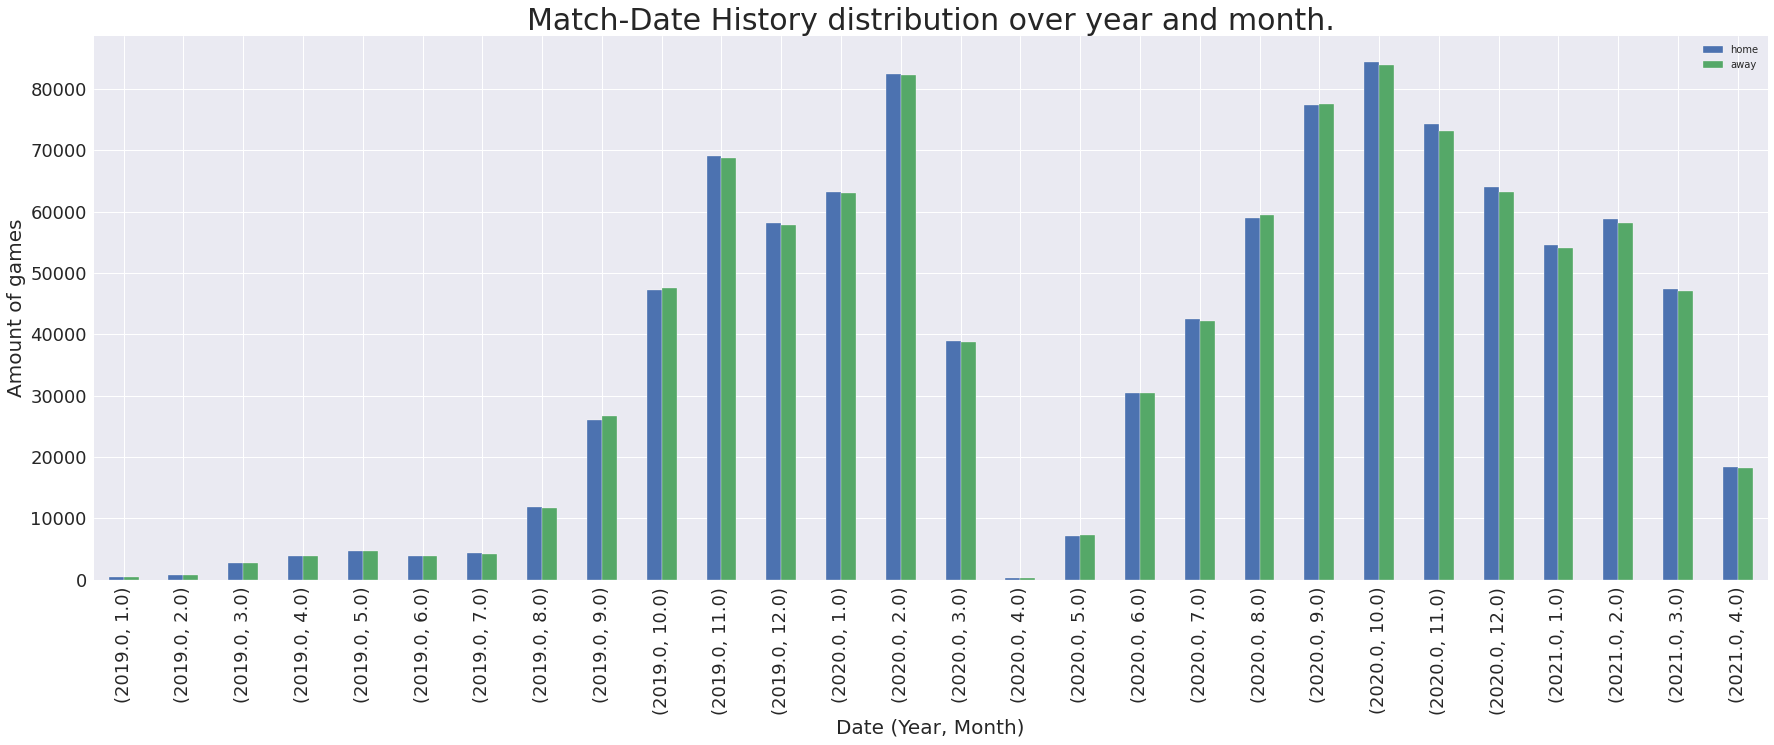

In [8]:
s = 'away_team_history_match_date_'
s2 = 'home_team_history_match_date_'
s_id = 'away_team_history_league_id'
s_id = 'home_team_history_league_id'

column_names = ["date"]
new_df = pd.DataFrame(columns = column_names)

history_df = df.loc[:, df.columns.str.contains(s)| df.columns.str.contains(s2)|(df.columns == 'id')]
history_df = pd.wide_to_long(history_df, stubnames=[s,s2], i="id",j='i')

history_df['home'] = pd.to_datetime(history_df['home_team_history_match_date_'], errors='coerce')
history_df['away'] = pd.to_datetime(history_df['away_team_history_match_date_'], errors='coerce')

home_count = history_df.groupby([history_df["home"].dt.year, history_df["home"].dt.month])['home'].count()
away_count = history_df.groupby([history_df["away"].dt.year, history_df["away"].dt.month])['away'].count()


res = pd.concat([home_count, away_count], axis=1)


style.use(style='seaborn')
ax = res.plot(kind="bar",figsize=(30, 10))
ax.set_title("Match-Date History distribution over year and month.",fontsize=30)
ax.set_xlabel("Date (Year, Month)",fontsize=20)
ax.set_ylabel("Amount of games",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.show()



The game history naturally spans a bit further back than the match-date feature.

## Win and Loss Streaks

This guy gave me the idea: https://www.kaggle.com/henriqueweber/football-results-prediction

Adding wins and loss streaks might give extra insights into how we can predict results.

In [9]:
def add_streak(df):
    h_t_goal = "home_team_history_goal_"
    h_t_opp_goal = "home_team_history_opponent_goal_"
    a_t_goal = "away_team_history_goal_"
    a_t_opp_goal = "away_team_history_opponent_goal_"
    df["away_streak"] = np.nan
    df["home_streak"] = np.nan
    df['streak_type'] = np.nan
    def apply_streaks(x):
        home_streak = 0
        away_streak = 0
        home_streak_over = False
        away_streak_over = False
        home_streak_type = None
        away_streak_type = None
        
        if  x[h_t_goal+str(1)] > x[h_t_opp_goal+str(1)]:
            home_win_streak = True
            home_streak_type = 'win'
        elif x[h_t_goal+str(1)] < x[h_t_opp_goal+str(1)]:
            home_win_streak = False
            home_streak_type = 'loss'
        else:
            home_streak_type = 'draw'
            
        if  x[a_t_goal+str(1)] > x[a_t_opp_goal+str(1)]:
            away_win_streak = True
            away_streak_type = 'win'
        elif x[a_t_goal+str(1)] < x[a_t_opp_goal+str(1)]:
            away_win_streak = False
            away_streak_type = 'loss'
        else:
            away_streak_type = 'draw'
            
        def check_streak(streak,streak_over,streak_type,team_goal,opp_goal):
            if not streak_over and streak_type=='win' and team_goal > opp_goal:
                streak+=1
            elif not streak_over and streak_type=='loss' and team_goal < opp_goal:
                streak+=1
            elif not streak_over and streak_type =='draw' and team_goal == opp_goal:
                streak+=1
            else:
                streak_over = True
            return streak, streak_over
                
        for i in range(1,11):
            if not home_streak_over:
                home_streak, home_streak_over = check_streak(home_streak,home_streak_over, home_streak_type, x[h_t_goal+str(i)],x[h_t_opp_goal+str(i)])
            if not away_streak_over:
                away_streak, away_streak_over = check_streak(away_streak,away_streak_over, away_streak_type, x[a_t_goal+str(i)],x[a_t_opp_goal+str(i)])
            
        return pd.Series([home_streak,home_streak_type,away_streak,away_streak_type],index=['home_streak','home_streak_type','away_streak','away_streak_type'])

    
    df[['home_streak','home_streak_type','away_streak','away_streak_type']] = df.apply(lambda x: apply_streaks(x), axis=1)
    return df


In [10]:
temp_df = add_streak(df)

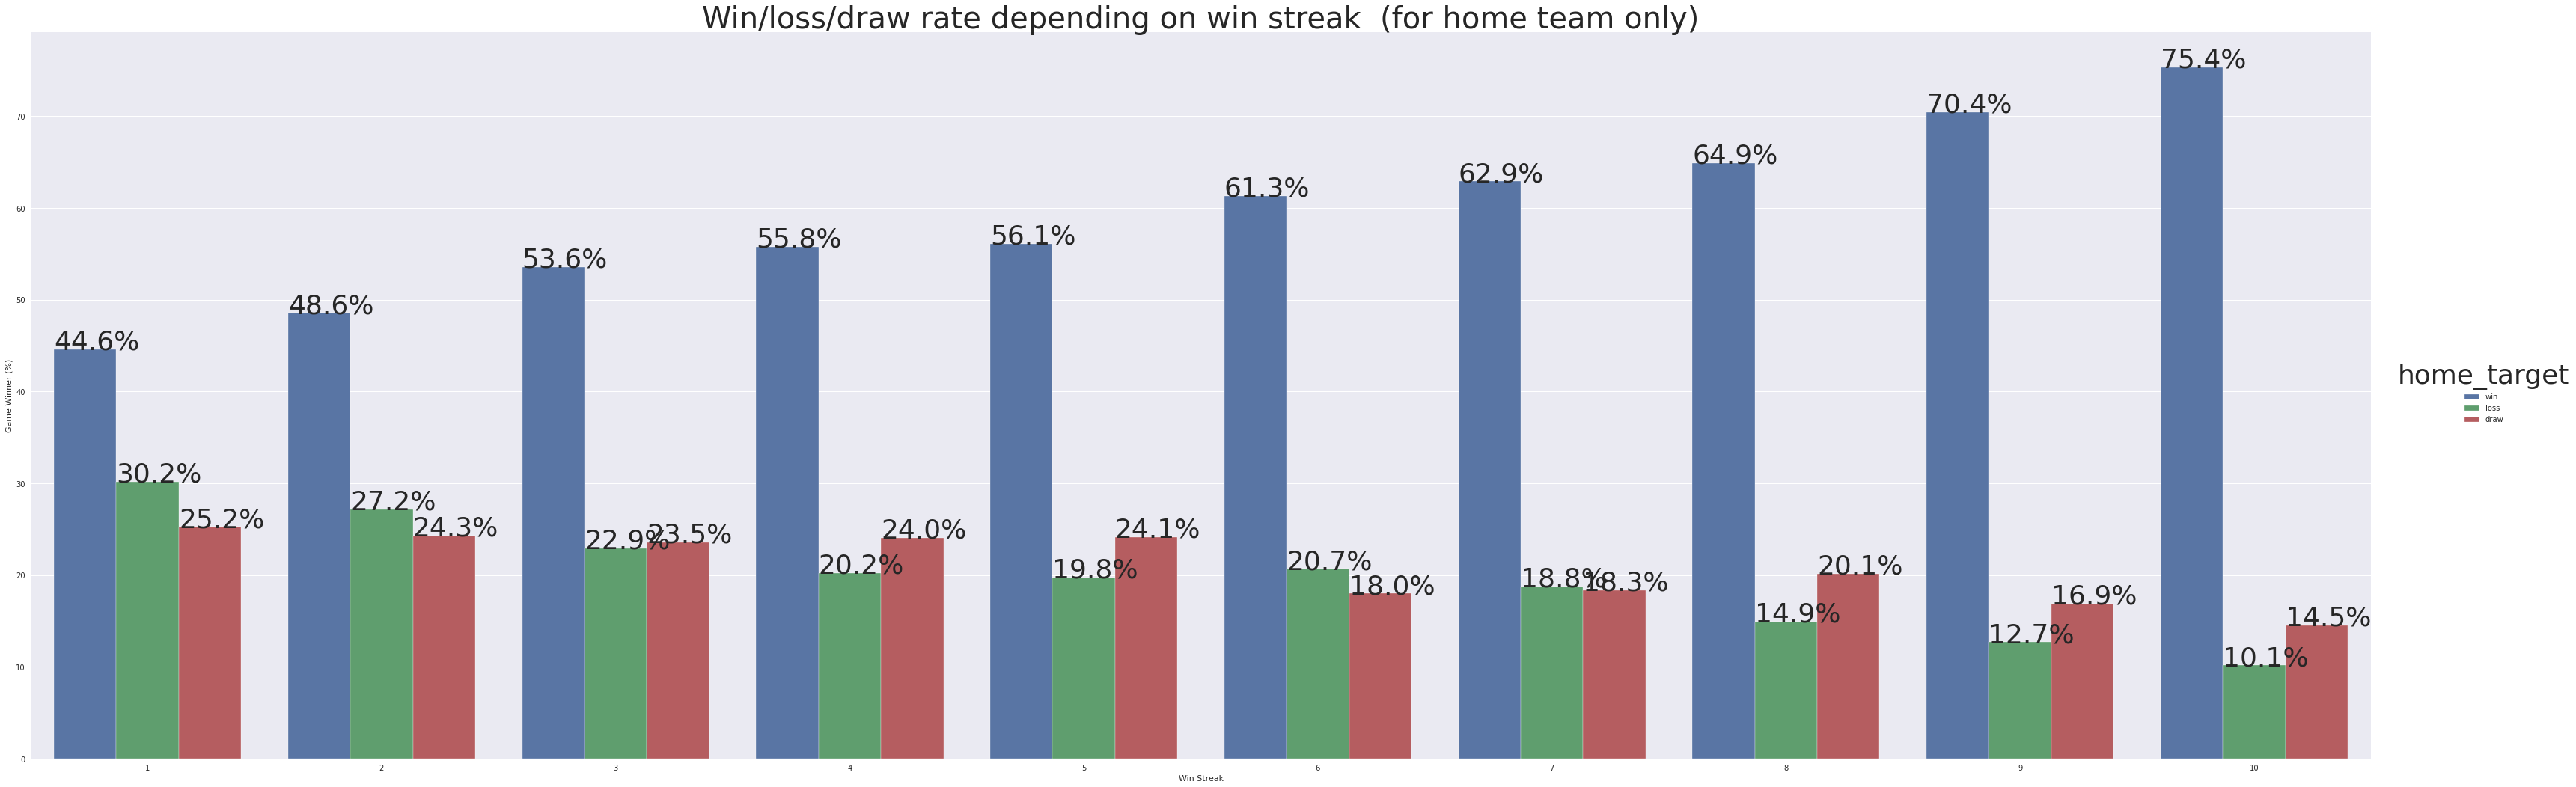

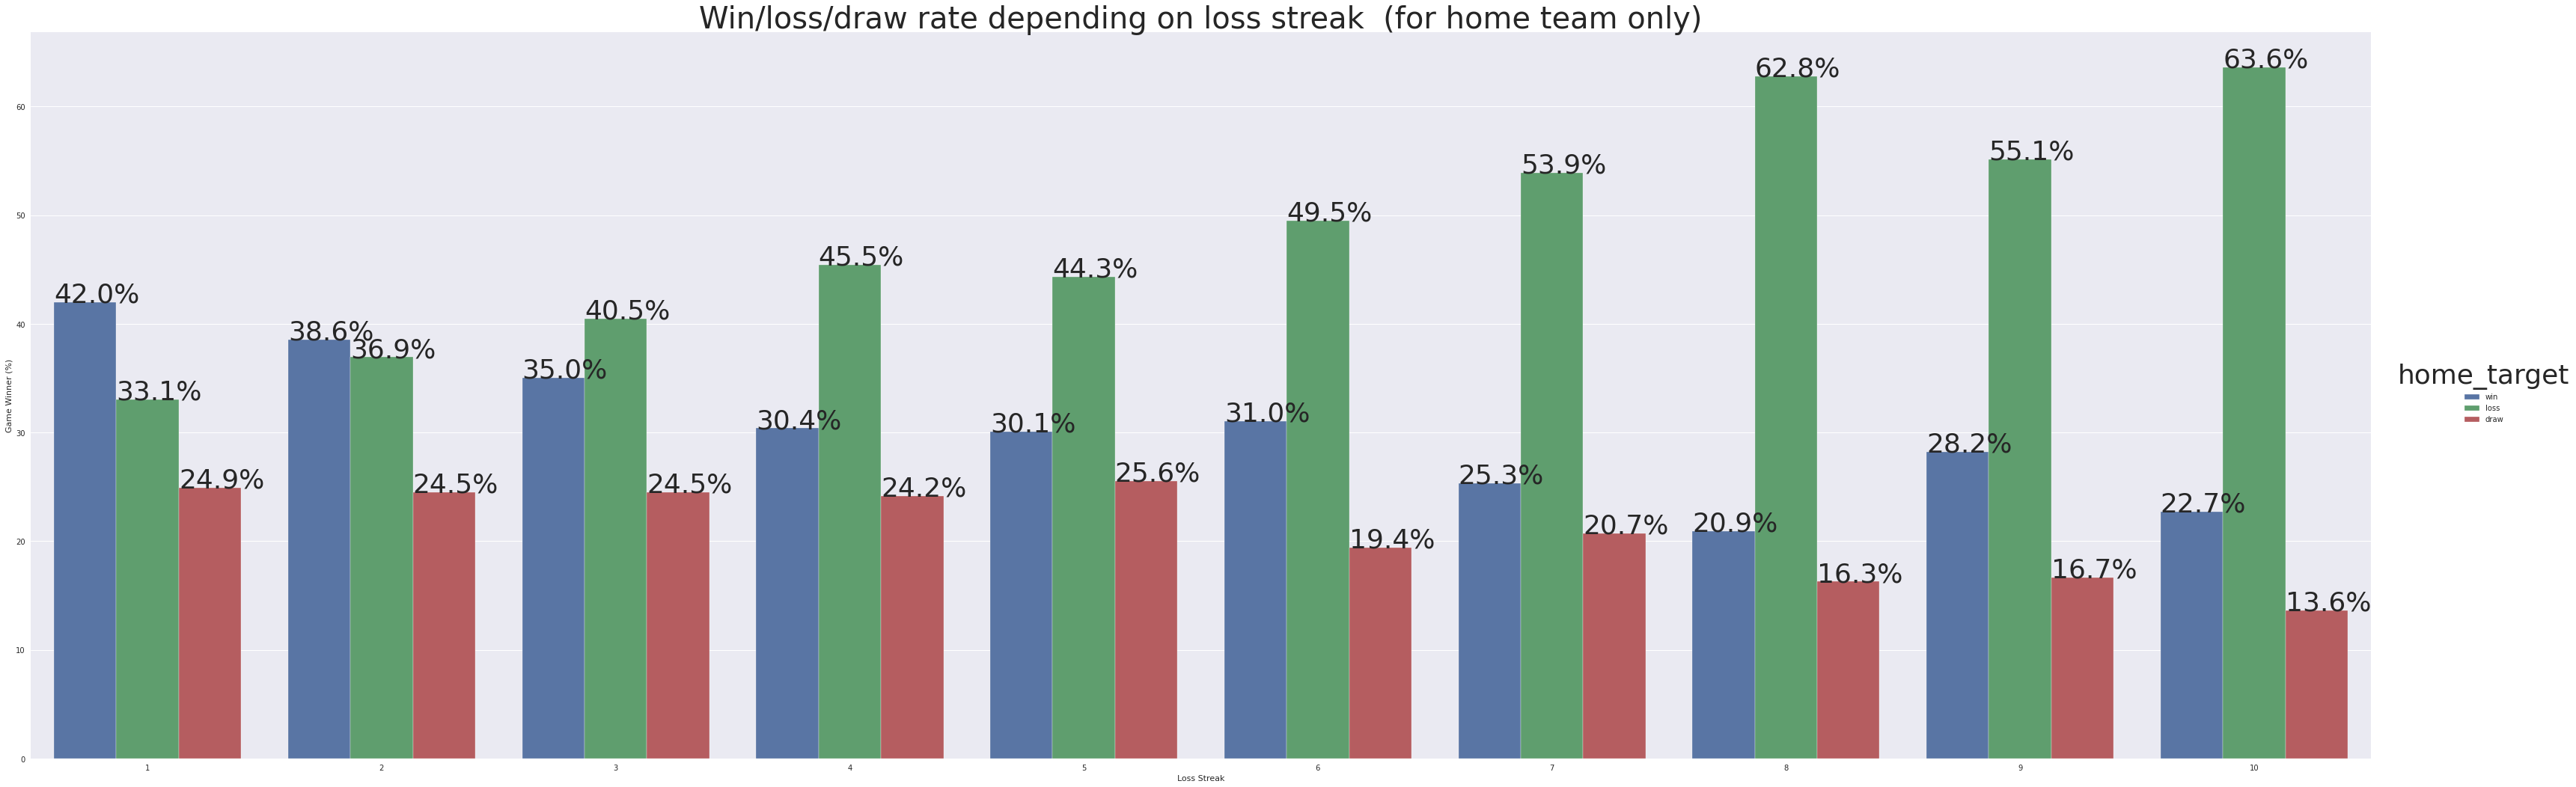

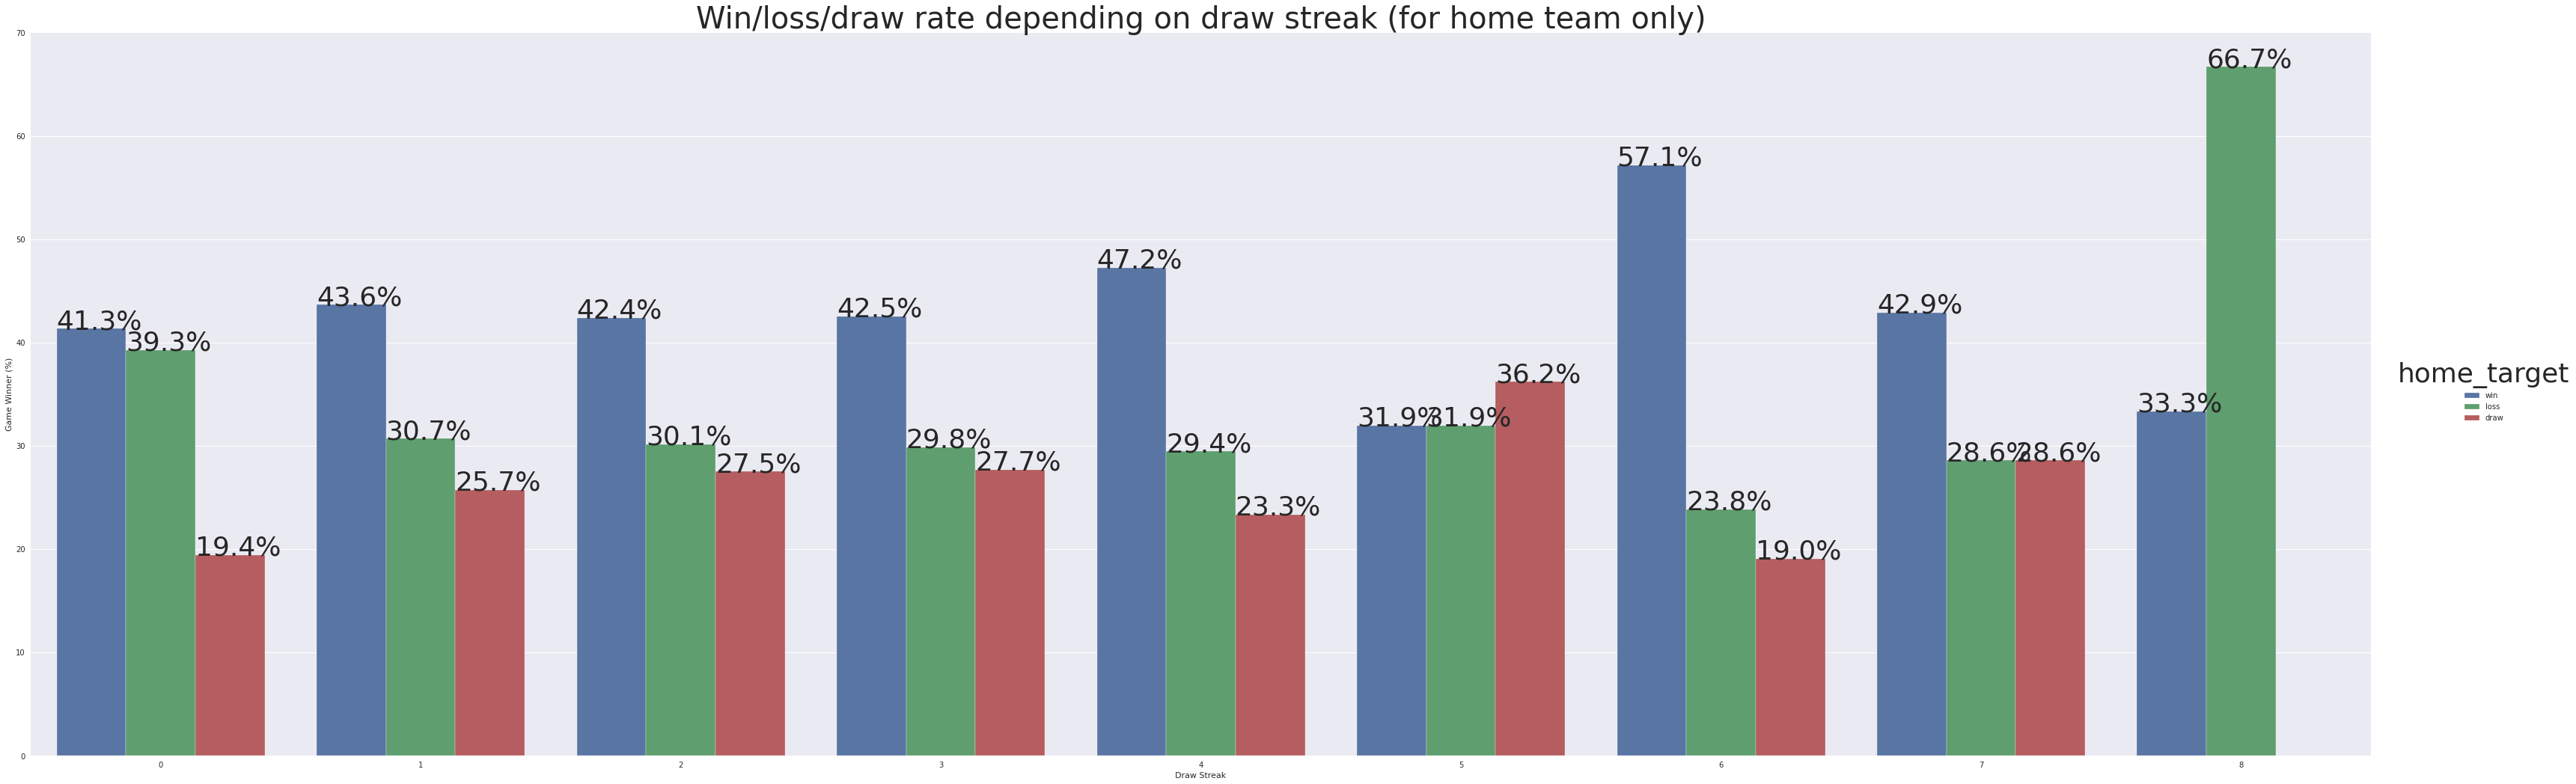

In [11]:

#grouped = temp_df.groupby(['target'])
#display(grouped['home'])
hue_order = ['win','loss','draw']
temp_df["home_target"] = 'draw'

temp_df.loc[temp_df['target']=='home','home_target'] = 'win'
temp_df.loc[temp_df['target']=='away','home_target'] = 'loss'

t1 = temp_df.loc[temp_df['home_streak_type']=='win']
grouped = t1.groupby(['home_streak','home_streak_type'])['home_target'].value_counts(normalize=True)
grouped = grouped.mul(100)
grouped = grouped.rename('percent').reset_index()
g = sns.catplot(x="home_streak",y='percent',hue='home_target',kind='bar',hue_order=hue_order,data=grouped,height=15,aspect=3)
plt.title("Win/loss/draw rate depending on win streak  (for home team only)", fontsize=40)
g.set_axis_labels("Win Streak","Game Winner (%)")
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.show()

t1 = temp_df.loc[temp_df['home_streak_type']=='loss']
grouped = t1.groupby(['home_streak','home_streak_type'])['home_target'].value_counts(normalize=True)
grouped = grouped.mul(100)
grouped = grouped.rename('percent').reset_index()
g = sns.catplot(x="home_streak",y='percent',hue='home_target',kind='bar',hue_order=hue_order,data=grouped,height=15,aspect=3)
plt.title("Win/loss/draw rate depending on loss streak  (for home team only)", fontsize=40)
g.set_axis_labels("Loss Streak","Game Winner (%)")
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.show()

t1 = temp_df.loc[temp_df['home_streak_type']=='draw']
grouped = t1.groupby(['home_streak','home_streak_type'])['home_target'].value_counts(normalize=True)
grouped = grouped.mul(100)
grouped = grouped.rename('percent').reset_index()

g = sns.catplot(x="home_streak",y='percent',hue='home_target',kind='bar',hue_order=hue_order,data=grouped,height=15,aspect=3)
plt.title("Win/loss/draw rate depending on draw streak (for home team only)", fontsize=40)
g.set_axis_labels("Draw Streak","Game Winner (%)")
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.show()

There is a very clear correlation between increase in wins and losses to win streak and loss streak respectively for the home team. Win rate increases from 45% to 75% when win streak increases from 1 to 10. Similarly loss rate increases from 33% to 64% between loss streak of 1 and 10. The correlation between draw rate and draw streaks is not as obvious, though there is a small increase in draw rate for larger draw streaks. Note that there are not as many draw streaks as there are win and loss streaks.

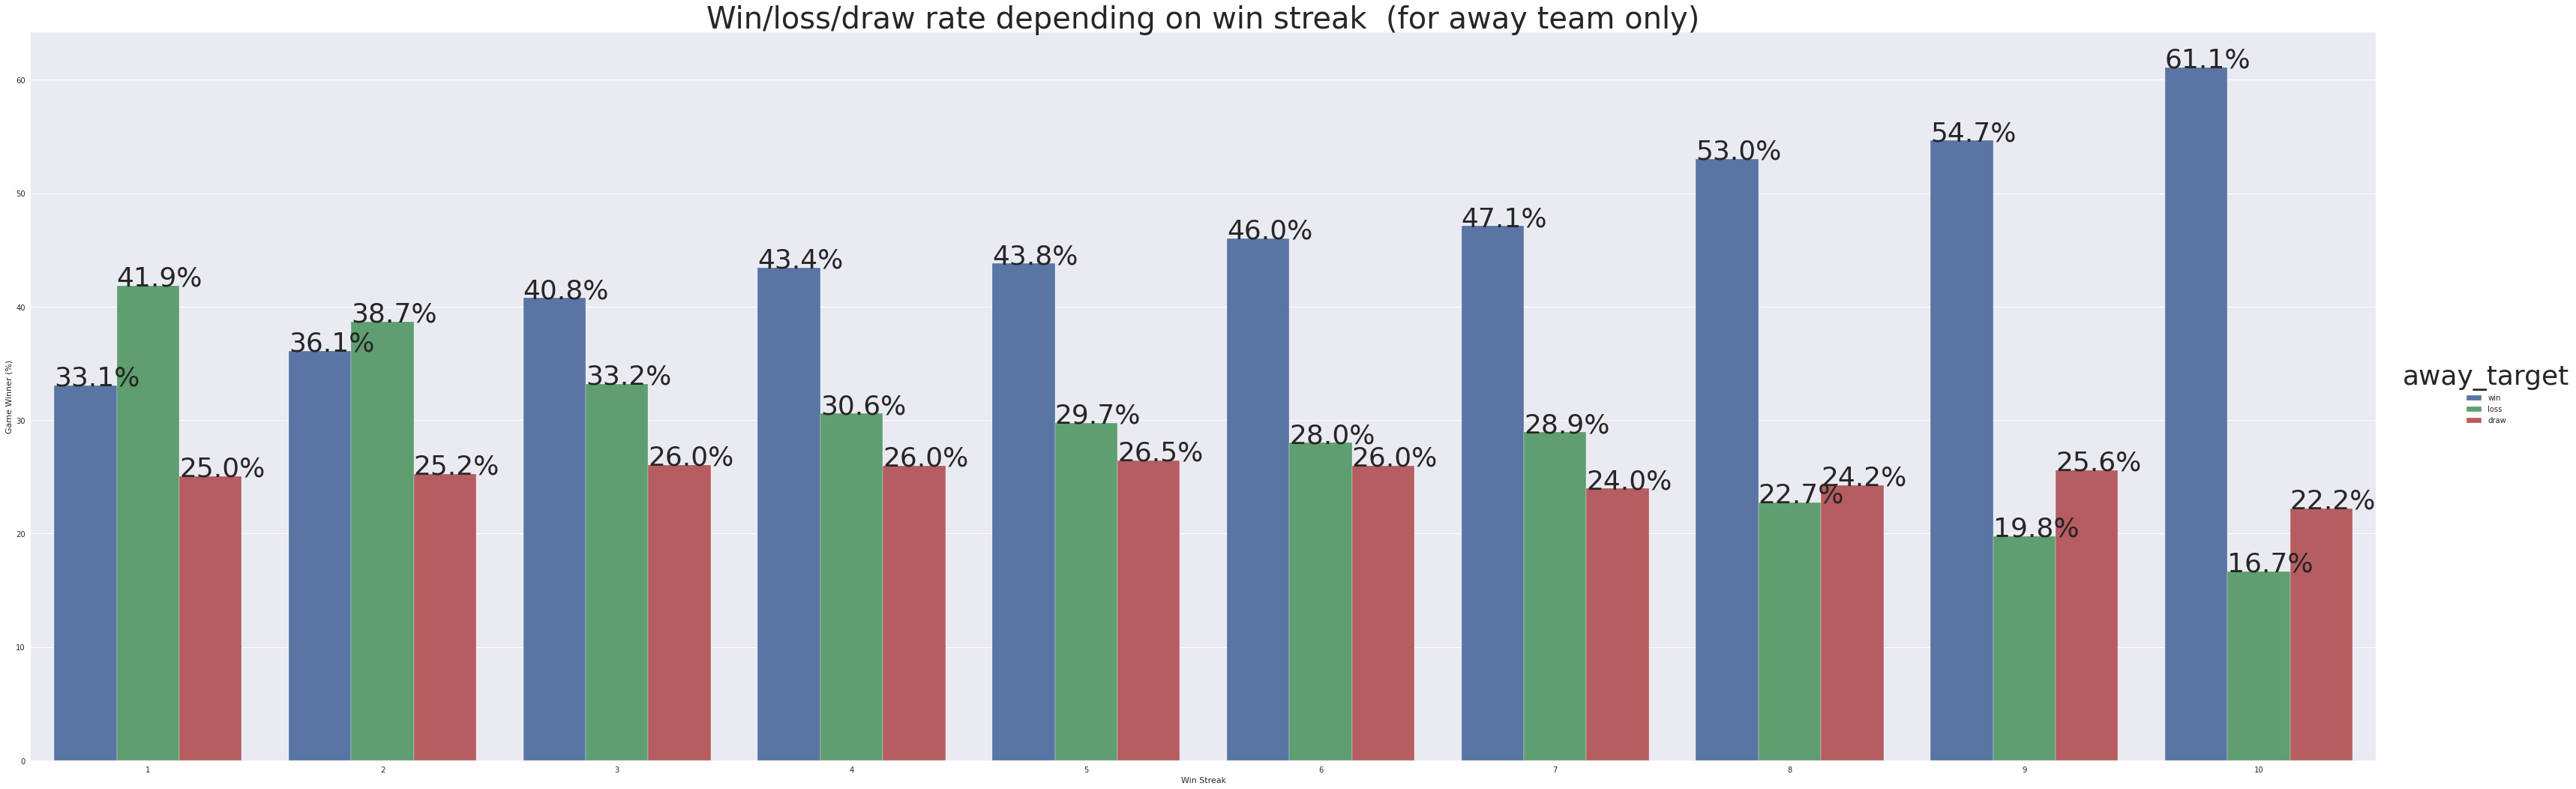

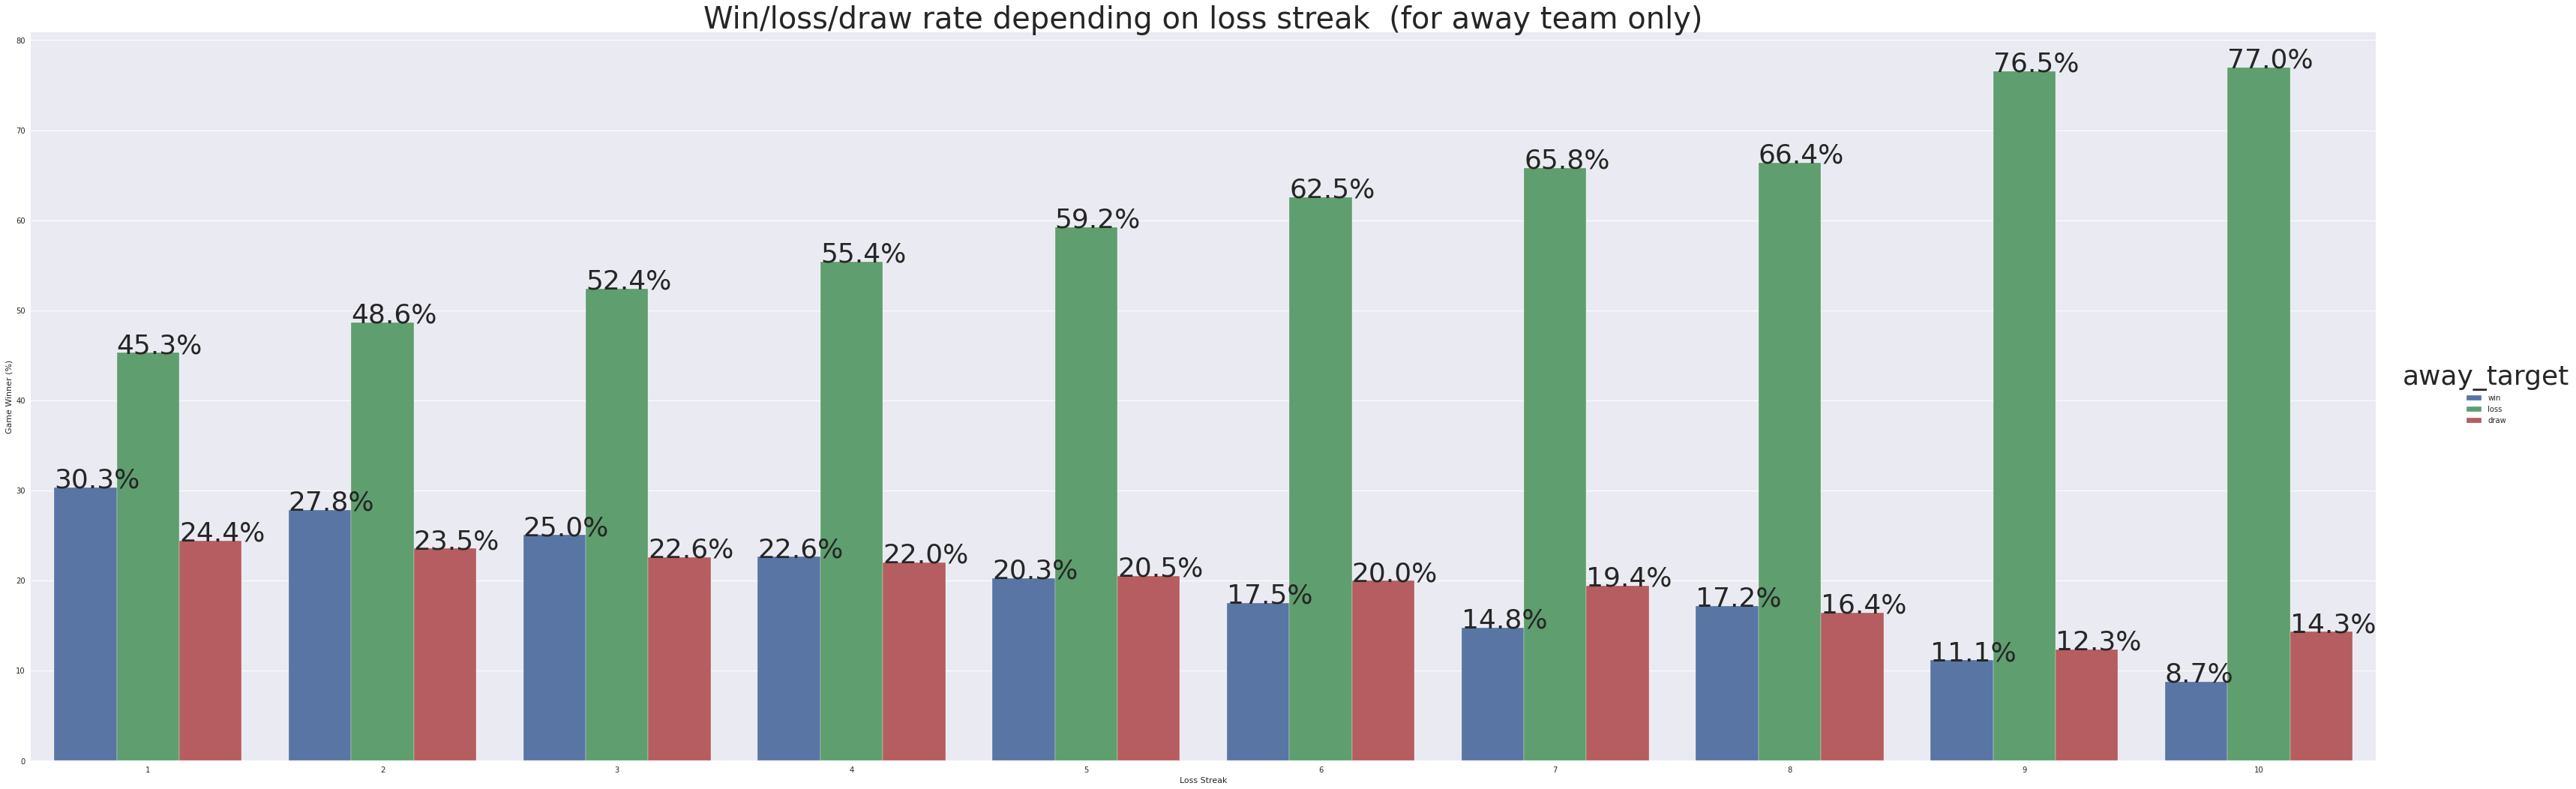

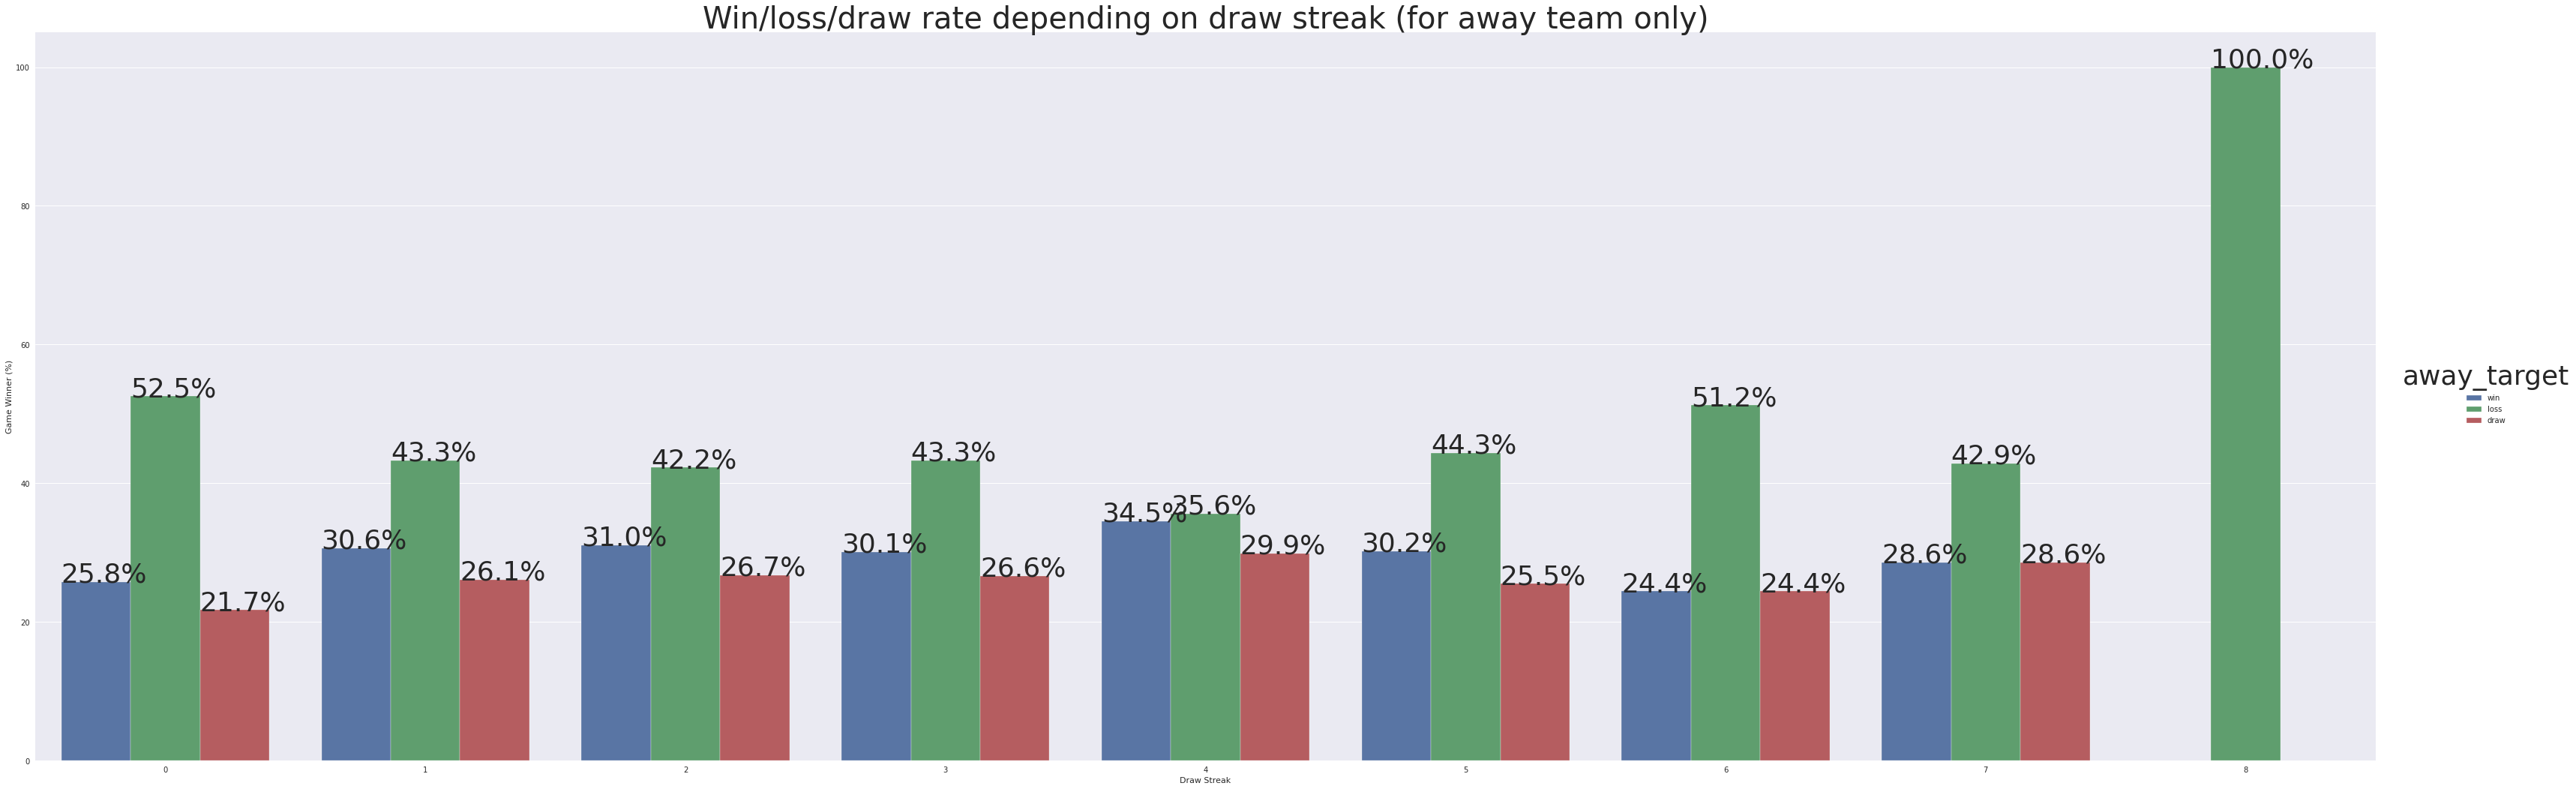

In [12]:
hue_order = ['win','loss','draw']
temp_df["away_target"] = 'draw'

temp_df.loc[temp_df['target']=='away','away_target'] = 'win'
temp_df.loc[temp_df['target']=='home','away_target'] = 'loss'

t1 = temp_df.loc[temp_df['away_streak_type']=='win']
grouped = t1.groupby(['away_streak','away_streak_type'])['away_target'].value_counts(normalize=True)
grouped = grouped.mul(100)
grouped = grouped.rename('percent').reset_index()
g = sns.catplot(x="away_streak",y='percent',hue='away_target',kind='bar',hue_order=hue_order,data=grouped,height=15,aspect=3)
plt.title("Win/loss/draw rate depending on win streak  (for away team only)", fontsize=40)
g.set_axis_labels("Win Streak","Game Winner (%)")
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.show()

t1 = temp_df.loc[temp_df['away_streak_type']=='loss']
grouped = t1.groupby(['away_streak','away_streak_type'])['away_target'].value_counts(normalize=True)
grouped = grouped.mul(100)
grouped = grouped.rename('percent').reset_index()
g = sns.catplot(x="away_streak",y='percent',hue='away_target',kind='bar',hue_order=hue_order,data=grouped,height=15,aspect=3)
plt.title("Win/loss/draw rate depending on loss streak  (for away team only)", fontsize=40)
g.set_axis_labels("Loss Streak","Game Winner (%)")
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.show()

t1 = temp_df.loc[temp_df['away_streak_type']=='draw']
grouped = t1.groupby(['away_streak','away_streak_type'])['away_target'].value_counts(normalize=True)
grouped = grouped.mul(100)
grouped = grouped.rename('percent').reset_index()

g = sns.catplot(x="away_streak",y='percent',hue='away_target',kind='bar',hue_order=hue_order,data=grouped,height=15,aspect=3)
plt.title("Win/loss/draw rate depending on draw streak (for away team only)", fontsize=40)
g.set_axis_labels("Draw Streak","Game Winner (%)")
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.show()

The same patterns can be seen for the away team when it come to form. There are larger win rates for teams that are on good form while there are larger loss rates for teams on bad form.

# Points System

## Work in progress